In [ ]:
%pip install opendatasets keras-tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
import keras_tuner as kt
import opendatasets as od
import tensorflow as tf
import time
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras.src.saving')

from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Flatten,Dense, Activation, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow import keras
from datetime import datetime

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Cargue DataSet

In [ ]:
od.download("https://www.kaggle.com/datasets/yusufemir/lemon-quality-dataset")

Skipping, found downloaded files in "./lemon-quality-dataset" (use force=True to force download)


### Función para Cargar Imágenes del Dataset

Esta función permite cargar imágenes manualmente usando OpenCV, útil para tener control total sobre el preprocesamiento.

In [ ]:
def load_images_from_dataset(dataset_path, clases, img_size=(75, 75), test_size=0.15, val_size=0.15, random_state=42):
    """
    Carga imágenes del dataset usando OpenCV con división train/val/test.
    """

    print("="*70)
    print("CARGANDO IMÁGENES CON OPENCV")
    print("="*70)

    images = []
    labels = []
    label_to_idx = {clase: idx for idx, clase in enumerate(clases)}

    stats = {
        'total_loaded': 0,
        'total_skipped': 0,
        'by_class': {}
    }

    # Cargar imágenes por clase
    for clase in clases:
        clase_path = Path(dataset_path) / clase

        if not clase_path.exists():
            print(f" Advertencia: La carpeta '{clase}' no existe en {dataset_path}")
            continue

        # Obtener todas las imágenes
        img_files = list(clase_path.glob('*.jpg')) + list(clase_path.glob('*.png'))
        loaded_count = 0
        skipped_count = 0

        print(f"\n Procesando clase '{clase}': {len(img_files)} archivos encontrados")

        for img_path in tqdm(img_files, desc=f"  Cargando {clase}"):
            try:
                # Leer imagen con OpenCV
                img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)

                if img is None:
                    skipped_count += 1
                    continue

                # Convertir BGR a RGB (OpenCV usa BGR por defecto)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Redimensionar a tamaño objetivo
                img = cv2.resize(img, img_size)

                images.append(img)
                labels.append(label_to_idx[clase])
                loaded_count += 1

            except Exception as e:
                skipped_count += 1
                continue

        stats['by_class'][clase] = {
            'loaded': loaded_count,
            'skipped': skipped_count
        }
        stats['total_loaded'] += loaded_count
        stats['total_skipped'] += skipped_count

        print(f" Cargadas: {loaded_count} | Omitidas: {skipped_count}")

    # Convertir a arrays numpy
    X = np.array(images, dtype=np.uint8)
    y = np.array(labels, dtype=np.int32)

    print(f"\n{'='*70}")
    print(f"RESUMEN DE CARGA")
    print(f"{'='*70}")
    print(f"Total imágenes cargadas: {stats['total_loaded']}")
    print(f"Total imágenes omitidas: {stats['total_skipped']}")
    print(f"Forma del array X: {X.shape}")
    print(f"Forma del array y: {y.shape}")

    # Dividir en train/val/test
    print(f"\n{'='*70}")
    print(f"DIVISIÓN DE DATOS")
    print(f"{'='*70}")

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Luego separar train y val del resto
    val_size_adjusted = val_size / (1 - test_size)  # Ajustar proporción
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
    )

    # Shuffle adicional de cada conjunto para robustez
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)
    X_val, y_val = shuffle(X_val, y_val, random_state=random_state)
    X_test, y_test = shuffle(X_test, y_test, random_state=random_state)

    print(f"Train: {X_train.shape[0]} imágenes ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Val:   {X_val.shape[0]} imágenes ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"Test:  {X_test.shape[0]} imágenes ({X_test.shape[0]/len(X)*100:.1f}%)")
    print(f"{'='*70}\n")

    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'class_names': clases,
        'stats': stats
    }

print(" Función 'load_images_from_dataset' definida correctamente")

✓ Función 'load_images_from_dataset' definida correctamente


In [ ]:
# Configuración del dataset
dataset_path = Path('/content/lemon-quality-dataset/lemon_dataset')
clases = ['bad_quality', 'good_quality', 'empty_background']

print("="*60)
print("ANÁLISIS DEL DATASET - LEMON CLASSIFICATION")
print("="*60)
print(f"Ruta del dataset: {dataset_path}")

ANÁLISIS DEL DATASET - LEMON CLASSIFICATION
Ruta del dataset: /content/lemon-quality-dataset/lemon_dataset


## 4.1 Análisis del Dataset

En esta sección se realizará el análisis completo del dataset de limones, incluyendo:
- Distribución de clases
- Dimensiones de las imágenes
- Estadísticas de píxeles (RGB)
- Ratio de desbalance

### 1. Distribución de Clases

In [ ]:
# Contar número de imágenes por clase
distribucion_clases = {}
for clase in clases:
    ruta_clase = dataset_path / clase
    num_imagenes = len(list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png')))
    distribucion_clases[clase] = num_imagenes
    print(f"{clase}: {num_imagenes} imágenes")

print(f"\nTotal de imágenes: {sum(distribucion_clases.values())}")

bad_quality: 951 imágenes
good_quality: 1125 imágenes
empty_background: 452 imágenes

Total de imágenes: 2528


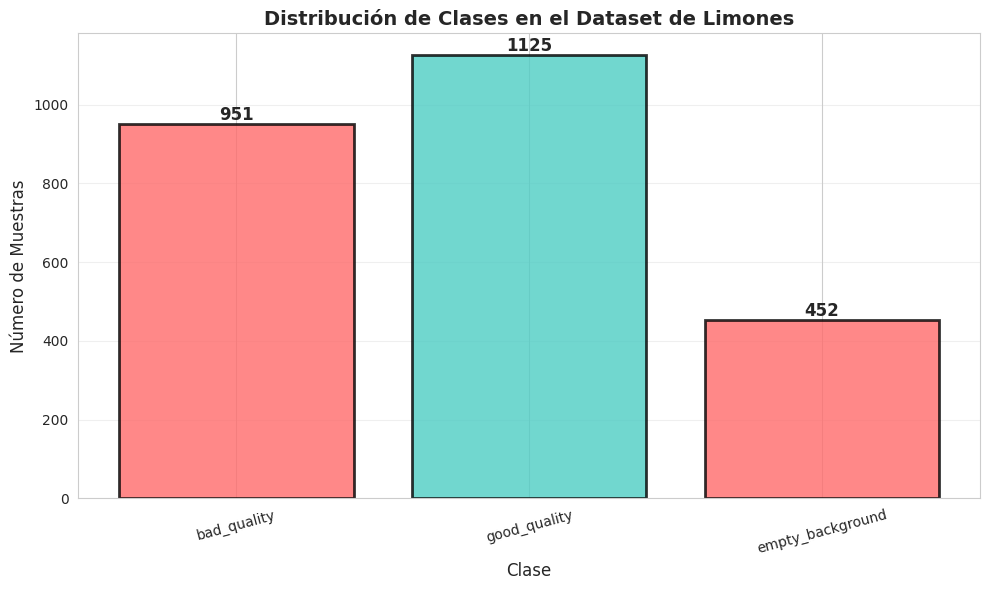

In [ ]:
# Gráfico de barras - Distribución de clases
plt.figure(figsize=(10, 6))
colores = ['#FF6B6B', '#4ECDC4']
barras = plt.bar(distribucion_clases.keys(), distribucion_clases.values(),
                 color=colores, alpha=0.8, edgecolor='black', linewidth=2)

# Añadir valores en las barras
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura,
             f'{int(altura)}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Distribución de Clases en el Dataset de Limones', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de Muestras', fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 2. Dimensiones de las Imágenes

In [ ]:
# Analizar dimensiones de las imágenes
dimensiones = []
for clase in clases:
    ruta_clase = dataset_path / clase
    imagenes = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png'))

    for img_path in imagenes[:20]:  # Revisar primeras 20 de cada clase
        img = Image.open(img_path)
        dimensiones.append((img.width, img.height, len(img.getbands())))

# Encontrar dimensiones únicas
dimensiones_unicas = list(set(dimensiones))
print("Dimensiones encontradas en el dataset:")
for dim in dimensiones_unicas:
    count = dimensiones.count(dim)
    print(f"  - {dim[0]} × {dim[1]} × {dim[2]} (Ancho × Alto × Canales): {count} imágenes")

# Determinar dimensión más común
dim_comun = max(set(dimensiones), key=dimensiones.count)
print(f"\n Dimensión más común: {dim_comun[0]} × {dim_comun[1]} × {dim_comun[2]} (Ancho × Alto × Canales)")

Dimensiones encontradas en el dataset:
  - 300 × 300 × 3 (Ancho × Alto × Canales): 60 imágenes

✓ Dimensión más común: 300 × 300 × 3 (Ancho × Alto × Canales)


### 3. Estadísticas de Píxeles (RGB)

In [ ]:
# Calcular estadísticas de píxeles por canal RGB
pixeles_r, pixeles_g, pixeles_b = [], [], []
num_muestras = 50  # Muestras por clase para análisis

print(f"Recolectando {num_muestras} muestras por clase...\n")

for clase in clases:
    ruta_clase = dataset_path / clase
    imagenes = list(ruta_clase.glob('*.jpg')) + list(ruta_clase.glob('*.png'))
    print(f"   Procesando {clase}: {len(imagenes)} imágenes encontradas (usando {min(num_muestras, len(imagenes))})")

    for img_path in imagenes[:num_muestras]:
        img = Image.open(img_path).convert('RGB')
        img_array = np.array(img)

        # Muestreo aleatorio de píxeles (para eficiencia)
        muestra_indices = np.random.choice(img_array.shape[0] * img_array.shape[1],
                                          size=min(1000, img_array.shape[0] * img_array.shape[1]),
                                          replace=False)
        pixeles_planos = img_array.reshape(-1, 3)[muestra_indices]

        pixeles_r.extend(pixeles_planos[:, 0])
        pixeles_g.extend(pixeles_planos[:, 1])
        pixeles_b.extend(pixeles_planos[:, 2])

# Convertir a arrays numpy
pixeles_r = np.array(pixeles_r)
pixeles_g = np.array(pixeles_g)
pixeles_b = np.array(pixeles_b)

# Calcular y mostrar estadísticas GLOBALES (todas las clases combinadas)
print("\n" + "="*60)
print("ESTADÍSTICAS GLOBALES DE PÍXELES")
print("="*60)
print(f"Total de píxeles analizados por canal: {len(pixeles_r):,}")
print(f"Muestras por clase: {num_muestras} imágenes × 2 clases = {num_muestras * 3} imágenes")
print("-" * 60)

estadisticas = {
    'Canal Rojo (R)': {'media': np.mean(pixeles_r), 'std': np.std(pixeles_r)},
    'Canal Verde (G)': {'media': np.mean(pixeles_g), 'std': np.std(pixeles_g)},
    'Canal Azul (B)': {'media': np.mean(pixeles_b), 'std': np.std(pixeles_b)}
}

for canal, stats in estadisticas.items():
    print(f"{canal}:")
    print(f"  Media: {stats['media']:.2f}")
    print(f"  Desviación Estándar: {stats['std']:.2f}")
    print()

Recolectando 50 muestras por clase...

  ✓ Procesando bad_quality: 951 imágenes encontradas (usando 50)
  ✓ Procesando good_quality: 1125 imágenes encontradas (usando 50)
  ✓ Procesando empty_background: 452 imágenes encontradas (usando 50)

ESTADÍSTICAS GLOBALES DE PÍXELES
Total de píxeles analizados por canal: 150,000
Muestras por clase: 50 imágenes × 2 clases = 150 imágenes
------------------------------------------------------------
Canal Rojo (R):
  Media: 138.09
  Desviación Estándar: 49.34

Canal Verde (G):
  Media: 129.56
  Desviación Estándar: 48.08

Canal Azul (B):
  Media: 92.27
  Desviación Estándar: 52.13



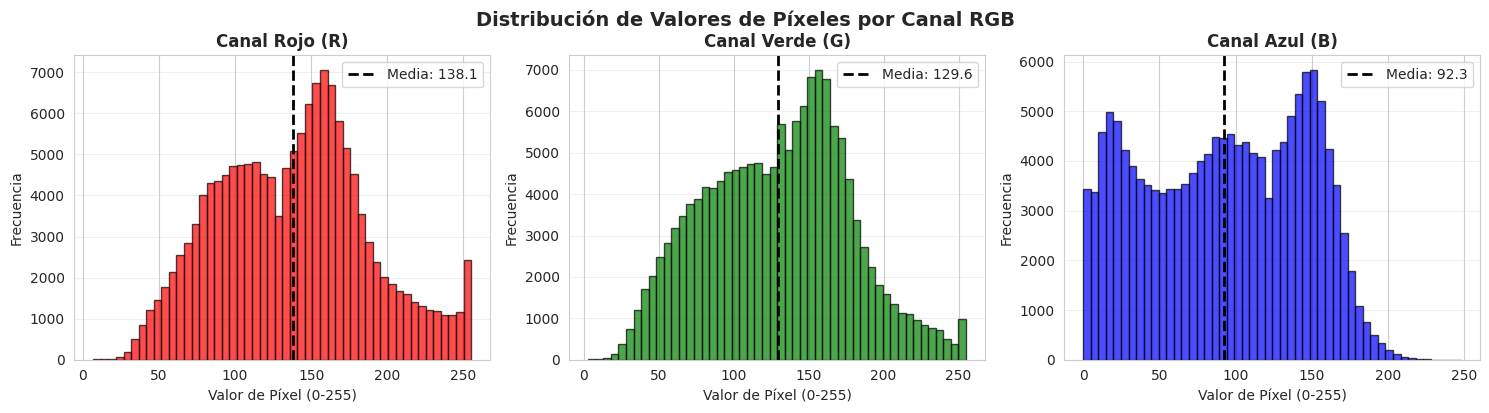

In [ ]:
# Visualización de distribución de píxeles por canal
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colores_canales = ['red', 'green', 'blue']
pixeles_canales = [pixeles_r, pixeles_g, pixeles_b]
titulos = ['Canal Rojo (R)', 'Canal Verde (G)', 'Canal Azul (B)']

for ax, pixeles, color, titulo in zip(axes, pixeles_canales, colores_canales, titulos):
    ax.hist(pixeles, bins=50, color=color, alpha=0.7, edgecolor='black')
    ax.set_title(titulo, fontweight='bold', fontsize=12)
    ax.set_xlabel('Valor de Píxel (0-255)', fontsize=10)
    ax.set_ylabel('Frecuencia', fontsize=10)
    ax.axvline(np.mean(pixeles), color='black', linestyle='--', linewidth=2,
               label=f'Media: {np.mean(pixeles):.1f}')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribución de Valores de Píxeles por Canal RGB',
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

### 4. Ratio de Desbalance

In [ ]:
# Calcular ratio de desbalance
clase_mayor = max(distribucion_clases.values())
clase_menor = min(distribucion_clases.values())
ratio_desbalance = clase_mayor / clase_menor

print("Análisis de Desbalance del Dataset")
print("=" * 50)
print(f"Clase con más muestras: {clase_mayor}")
print(f"Clase con menos muestras: {clase_menor}")
print(f"Ratio de desbalance: {ratio_desbalance:.2f}")
print()

Análisis de Desbalance del Dataset
Clase con más muestras: 1125
Clase con menos muestras: 452
Ratio de desbalance: 2.49



### Resumen del Análisis del Dataset

In [ ]:
# Resumen final del análisis
print("=" * 60)
print("RESUMEN DEL ANÁLISIS DEL DATASET")
print("=" * 60)
print(f"Total de imágenes: {sum(distribucion_clases.values())}")
print(f"Número de clases: {len(clases)}")
print(f" Dimensión común: {dim_comun[0]} × {dim_comun[1]} × {dim_comun[2]} (Ancho × Alto × Canales)")
print(f"Ratio de desbalance: {ratio_desbalance:.2f}", end=" ")
print("(DESBALANCEADO )" if ratio_desbalance > 1.5 else "(BALANCEADO )")
print()
print("Estadísticas RGB:")
for canal, stats in estadisticas.items():
    print(f"  {canal}: μ={stats['media']:.2f}, σ={stats['std']:.2f}")
print("=" * 60)

RESUMEN DEL ANÁLISIS DEL DATASET
Total de imágenes: 2528
Número de clases: 3
 Dimensión común: 300 × 300 × 3 (Ancho × Alto × Canales)
Ratio de desbalance: 2.49 (DESBALANCEADO )

Estadísticas RGB:
  Canal Rojo (R): μ=138.09, σ=49.34
  Canal Verde (G): μ=129.56, σ=48.08
  Canal Azul (B): μ=92.27, σ=52.13


## 4.2 Baseline y Arquitecturas

En esta sección implementaremos:
- **Fase 1**: Baseline MLP (red neuronal sin convoluciones)
- **Fase 2**: 3 arquitecturas CNN con complejidad progresiva

**Técnicas implementadas:**
- Batch Normalization
- Data Augmentation
- Dropout
- Early Stopping
- Learning Rate Scheduling

### Preparación de Datos

In [ ]:
# Configuración de parámetros
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 15
SEED = 42
FAST_RUN = False

if FAST_RUN:
    EPOCHS = 5
    BATCH_SIZE = 64
    TUNER_MAX_EPOCHS = 2        # Épocas máximas para tuner
    TUNER_SEARCH_EPOCHS = 2     # Épocas por trial en búsqueda
else:
    TUNER_MAX_EPOCHS = 8       # Épocas máximas para tuner
    TUNER_SEARCH_EPOCHS = 5    # Épocas por trial en búsqueda

# Establecer semilla para reproducibilidad
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("="*60)
print("CONFIGURACIÓN DE PARÁMETROS")
print("="*60)
print(f"Dimensiones de imagen: {IMG_HEIGHT}x{IMG_WIDTH})")
print(f"Batch size: {BATCH_SIZE}")
print(f"Épocas: {EPOCHS}")
print(f"Clases: {clases}")
print(f"Número de clases: {len(clases)}")
print("="*60)

 Modo normal: 20 épocas
 Keras Tuner: max_epochs=10, search_epochs=10
CONFIGURACIÓN DE PARÁMETROS
Dimensiones de imagen: 150x150)
Batch size: 32
Épocas: 15
Clases: ['bad_quality', 'good_quality', 'empty_background']
Número de clases: 3


In [ ]:
# Cargar datos usando la función OpenCV
# División: 70% train, 15% validation, 15% test

print("\n Cargando datos con OpenCV...")
data = load_images_from_dataset(
    dataset_path=dataset_path,
    clases=clases,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    test_size=0.15,
    val_size=0.15,
    random_state=SEED
)

# Extraer los datos
X_train = data['X_train']
X_val = data['X_val']
X_test = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']

# Convertir etiquetas a categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=len(clases))
y_val_cat = to_categorical(y_val, num_classes=len(clases))
y_test_cat = to_categorical(y_test, num_classes=len(clases))

# Normalizar los datos (convertir de [0, 255] a [0, 1])
print("\n Normalizando datos...")
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
print(" Datos normalizados a rango [0, 1]")

# Aplicar Data Augmentation al conjunto de entrenamiento
print("\n Aplicando Data Augmentation al conjunto de entrenamiento...")

datagen_augmented = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    shear_range=0.15,
    fill_mode='nearest'
)

# Ajustar el generador con los datos de entrenamiento
datagen_augmented.fit(X_train)

print(" Data Augmentation configurado")
print("\nTransformaciones aplicadas:")
print("  Rotación: ±20°")
print("  Desplazamiento horizontal/vertical: ±20%")
print("  Flip horizontal: Sí")
print("  Zoom: ±15%")
print("  Shear: ±15%")


 Cargando datos con OpenCV...
CARGANDO IMÁGENES CON OPENCV

 Procesando clase 'bad_quality': 951 archivos encontrados


  Cargando bad_quality: 100%|██████████| 951/951 [00:00<00:00, 1394.52it/s]


 Cargadas: 951 | Omitidas: 0

 Procesando clase 'good_quality': 1125 archivos encontrados


  Cargando good_quality: 100%|██████████| 1125/1125 [00:00<00:00, 1314.62it/s]


 Cargadas: 1125 | Omitidas: 0

 Procesando clase 'empty_background': 452 archivos encontrados


  Cargando empty_background: 100%|██████████| 452/452 [00:00<00:00, 1244.69it/s]


 Cargadas: 452 | Omitidas: 0

RESUMEN DE CARGA
Total imágenes cargadas: 2528
Total imágenes omitidas: 0
Forma del array X: (2528, 150, 150, 3)
Forma del array y: (2528,)

DIVISIÓN DE DATOS
Train: 1768 imágenes (69.9%)
Val:   380 imágenes (15.0%)
Test:  380 imágenes (15.0%)


 Normalizando datos...
 Datos normalizados a rango [0, 1]

 Aplicando Data Augmentation al conjunto de entrenamiento...
 Data Augmentation configurado

Transformaciones aplicadas:
  • Rotación: ±20°
  • Desplazamiento horizontal/vertical: ±20%
  • Flip horizontal: Sí
  • Zoom: ±15%
  • Shear: ±15%


### Funciones Auxiliares para Evaluación

In [ ]:
# Función para graficar historial de entrenamiento
def plot_training_history(history, model_name):
    """
    Grafica loss y accuracy durante el entrenamiento
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} - Loss', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('Época', fontsize=11)
    axes[0].set_ylabel('Loss', fontsize=11)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} - Accuracy', fontweight='bold', fontsize=13)
    axes[1].set_xlabel('Época', fontsize=11)
    axes[1].set_ylabel('Accuracy', fontsize=11)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Función para crear matriz de confusión
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Crea y muestra matriz de confusión
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Frecuencia'})
    plt.title(f'Matriz de Confusión - {model_name}', fontweight='bold', fontsize=14, pad=20)
    plt.ylabel('Clase Real', fontsize=12, fontweight='bold')
    plt.xlabel('Clase Predicha', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return cm

# Función para evaluar modelo
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    """
    Evalúa el modelo en train, val y test
    Retorna diccionario con métricas incluyendo precision, recall y f1-score macro
    """
    print(f"\n{'='*60}")
    print(f"EVALUACIÓN: {model_name}")
    print(f"{'='*60}")

    # Evaluar en cada conjunto
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    # Calcular overfitting
    overfitting = train_acc - val_acc

    # Predecir en test para calcular métricas adicionales
    y_pred_test = model.predict(X_test, verbose=0)
    y_pred_classes = np.argmax(y_pred_test, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calcular precision, recall, f1-score macro
    from sklearn.metrics import precision_score, recall_score, f1_score
    precision_macro = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
    recall_macro = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)
    f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro', zero_division=0)

    print(f"Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val Accuracy: {val_acc*100:.2f}%")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Precision (macro): {precision_macro*100:.2f}%")
    print(f"Recall (macro): {recall_macro*100:.2f}%")
    print(f"F1-Score (macro): {f1_macro*100:.2f}%")
    print(f"Overfitting (Train - Val): {overfitting*100:.2f}%")
    print(f"{'='*60}\n")

    return {
        'train_acc': train_acc * 100,
        'val_acc': val_acc * 100,
        'test_acc': test_acc * 100,
        'precision_macro': precision_macro * 100,
        'recall_macro': recall_macro * 100,
        'f1_macro': f1_macro * 100,
        'overfitting': overfitting * 100,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'test_loss': test_loss
    }

print(" Funciones auxiliares definidas correctamente")

✓ Funciones auxiliares definidas correctamente


---
## FASE 1: Baseline MLP

Red neuronal sin convoluciones:
- **Arquitectura**: Input → Flatten → Dense(128, relu) → Dense(64, relu) → Dense(num_clases, softmax)
- **Objetivo**: Establecer baseline para comparación

In [ ]:
# Construcción del modelo Baseline MLP
def build_baseline_mlp(input_shape, num_classes):
    """
    Modelo baseline sin convoluciones
    """
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu', name='dense_1'),
        keras.layers.Dense(64, activation='relu', name='dense_2'),
        keras.layers.Dense(num_classes, activation='softmax', name='output')
    ], name='Baseline_MLP')

    return model

# Crear modelo
baseline_mlp = build_baseline_mlp(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=len(clases)
)

# Compilar modelo
baseline_mlp.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO 0: BASELINE MLP")
print(f"{'='*60}")
baseline_mlp.summary()
print(f"{'='*60}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")


MODELO 0: BASELINE MLP


Model: "Baseline_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,579 (32.99 MB)

 Trainable params: 8,648,579 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

Timestamp: 2025-11-19 04:45:39


In [ ]:
# Entrenar Baseline MLP
print(f"\n{'='*60}")
print("ENTRENANDO BASELINE MLP")
print(f"{'='*60}\n")

start_time = time.time()

# Entrenar SIN data augmentation
history_mlp = baseline_mlp.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

end_time = time.time()
total_time = end_time - start_time
time_per_epoch = total_time / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch:.2f} segundos")
print(f"{'='*60}")


ENTRENANDO BASELINE MLP

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.6122 - loss: 7.7120 - val_accuracy: 0.6316 - val_loss: 1.0319
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7954 - loss: 0.7614 - val_accuracy: 0.9316 - val_loss: 0.2190
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9228 - loss: 0.2484 - val_accuracy: 0.8316 - val_loss: 0.5500
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8015 - loss: 0.8026 - val_accuracy: 0.8447 - val_loss: 0.6145
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9219 - loss: 0.3314 - val_accuracy: 0.9526 - val_loss: 0.1297
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9368 - loss: 0.2271 - val_accuracy: 0.9632 - val_loss: 0.1250
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9397 - loss: 0.2182 - val_accuracy: 0.9579 - val_loss: 0.0944
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9488 - loss: 0.1866 


EVALUACIÓN: Baseline MLP
Train Accuracy: 98.64%
Val Accuracy: 96.84%
Test Accuracy: 96.58%
Precision (macro): 97.22%
Recall (macro): 97.18%
F1-Score (macro): 97.20%
Overfitting (Train - Val): 1.80%



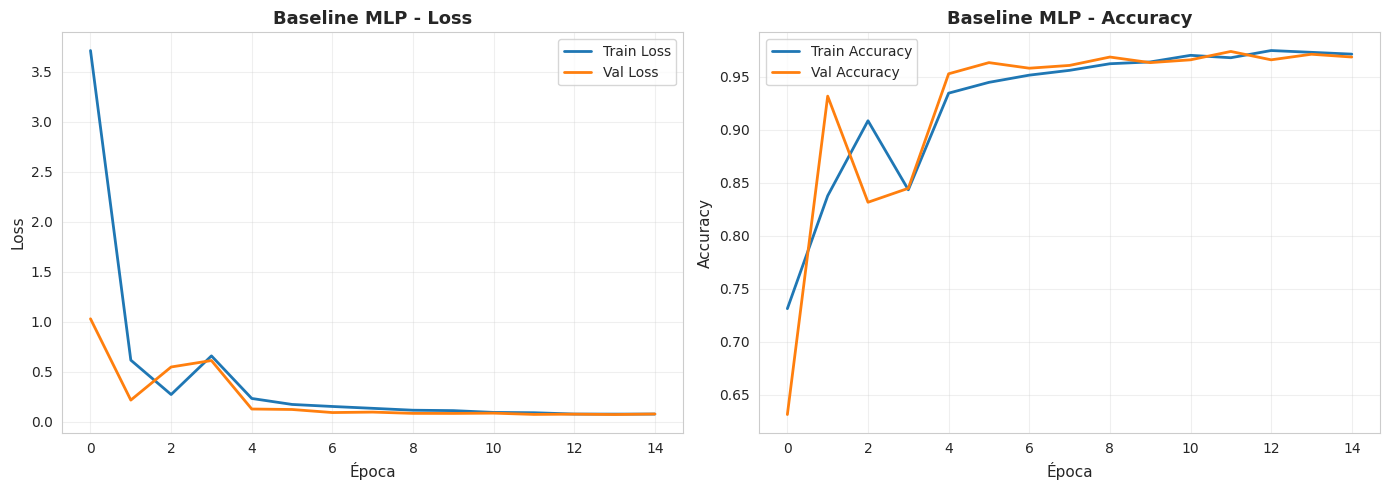

In [ ]:
# Evaluar Baseline MLP
metrics_mlp = evaluate_model(
    baseline_mlp,
    X_train, y_train_cat,
    X_val, y_val_cat,
    X_test, y_test_cat,
    "Baseline MLP"
)

# Graficar historial de entrenamiento
plot_training_history(history_mlp, "Baseline MLP")

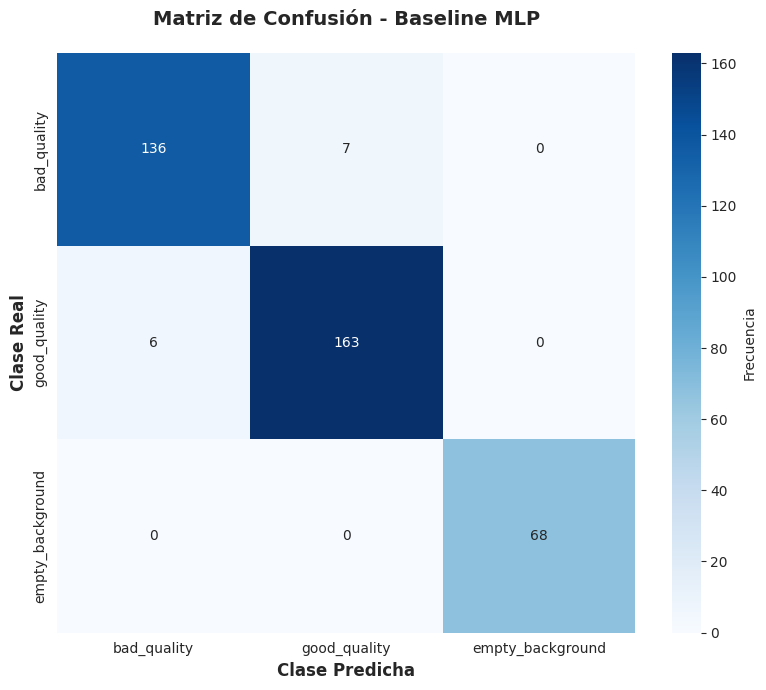


RESUMEN BASELINE MLP
Train Accuracy: 98.64%
Val Accuracy: 96.84%
Test Accuracy: 96.58%
Parámetros: 8,648,579
Tiempo/Época: 1.54 seg
Overfitting: 1.80%


In [ ]:
# Matriz de confusión para Baseline MLP
y_pred_mlp = baseline_mlp.predict(X_test, verbose=0)
y_pred_classes_mlp = np.argmax(y_pred_mlp, axis=1)
y_true_mlp = y_test

cm_mlp = plot_confusion_matrix(
    y_true_mlp,
    y_pred_classes_mlp,
    clases,
    "Baseline MLP"
)

# Guardar métricas del baseline
results_table = {
    'Exp': [0],
    'Arquitectura': ['MLP-Baseline'],
    'Train_Acc': [f"{metrics_mlp['train_acc']:.2f}"],
    'Val_Acc': [f"{metrics_mlp['val_acc']:.2f}"],
    'Test_Acc': [f"{metrics_mlp['test_acc']:.2f}"],
    'Precision': [f"{metrics_mlp['precision_macro']:.2f}"],
    'Recall': [f"{metrics_mlp['recall_macro']:.2f}"],
    'F1_Score': [f"{metrics_mlp['f1_macro']:.2f}"],
    'Params': [baseline_mlp.count_params()],
    'Time_per_Epoch': [f"{time_per_epoch:.2f}"],
    'Overfitting': [f"{metrics_mlp['overfitting']:.2f}"]
}

print("\n" + "="*80)
print("RESUMEN BASELINE MLP")
print("="*80)
print(f"Train Accuracy: {metrics_mlp['train_acc']:.2f}%")
print(f"Val Accuracy: {metrics_mlp['val_acc']:.2f}%")
print(f"Test Accuracy: {metrics_mlp['test_acc']:.2f}%")
print(f"Parámetros: {baseline_mlp.count_params():,}")
print(f"Tiempo/Época: {time_per_epoch:.2f} seg")
print(f"Overfitting: {metrics_mlp['overfitting']:.2f}%")
print("="*80)

---
## FASE 2: Arquitecturas CNN

Implementaremos 3 arquitecturas CNN con complejidad progresiva:

## 4.1 CNN 1: Arquitectura Simple con Optimización de Hiperparámetros

**Arquitectura Base:**
- 2 capas convolucionales (Conv32 → Conv64)
- Sin Batch Normalization
- Dropout solo en capas densas
- MaxPooling después de cada Conv

**Hiperparámetros a optimizar con Keras Tuner:**
- Learning rate
- Unidades en capas densas
- Dropout rate (rango limitado alrededor de 0.2)

In [ ]:
from IPython.display import clear_output

# Callback para limpiar output durante búsqueda
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        clear_output(wait=True)

✓ Callback de limpieza definido


### 4.1.1 Optimización de Hiperparámetros con Keras Tuner

In [ ]:
# Función de búsqueda para CNN1 con Keras Tuner
def build_cnn1_for_tuner(hp):
    # Hiperparámetros a optimizar
    dense_units_1 = hp.Choice('dense_units_1', values=[64, 128, 256])
    dense_units_2 = hp.Choice('dense_units_2', values=[32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Construir modelo CNN1
    model = keras.models.Sequential([
        keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Arquitectura fija: 2 capas convolucionales
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        keras.layers.MaxPooling2D((2, 2), name='pool1'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.MaxPooling2D((2, 2), name='pool2'),

        # Capas densas optimizables
        keras.layers.Flatten(name='flatten'),
        keras.layers.Dense(dense_units_1, activation='relu', name='dense1'),
        keras.layers.Dropout(dropout_rate, name='dropout1'),
        keras.layers.Dense(dense_units_2, activation='relu', name='dense2'),
        keras.layers.Dropout(dropout_rate, name='dropout2'),
        keras.layers.Dense(len(clases), activation='softmax', name='output')
    ], name='CNN1_Simple')

    # Compilar con learning rate optimizable
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" Función CNN1 para optimización definida")

✓ Función CNN1 para optimización definida


In [ ]:
# LIMPIAR CACHÉ DE KERAS TUNER
import shutil
import os

print("\n" + "="*70)
print("LIMPIANDO CACHÉ DE KERAS TUNER")
print("="*70)

cache_dirs = ['keras_tuner_cnn1', 'keras_tuner_cnn2', 'keras_tuner_cnn3']

for cache_dir in cache_dirs:
    if os.path.exists(cache_dir):
        try:
            shutil.rmtree(cache_dir)
            print(f" Eliminado: {cache_dir}")
        except Exception as e:
            print(f" No se pudo eliminar {cache_dir}: {e}")
    else:
        print(f"○ No existe: {cache_dir}")

print("="*70)


LIMPIANDO CACHÉ DE KERAS TUNER
○ No existe: keras_tuner_cnn1
○ No existe: keras_tuner_cnn2
○ No existe: keras_tuner_cnn3

✓ Caché limpiado. Los modelos se reconstruirán con IMG_SIZE=150x150


In [ ]:
# Configurar Keras Tuner para CNN1
print("="*70)
print("OPTIMIZACIÓN CNN1 - CONFIGURANDO KERAS TUNER")
print("="*70)

ClearTrainingOutput()

tuner_cnn1 = kt.Hyperband(
    build_cnn1_for_tuner,
    objective='val_accuracy',
    max_epochs=TUNER_MAX_EPOCHS,
    factor=3,
    directory='keras_tuner_cnn1',
    project_name='cnn1_optimization',
    overwrite=True
)

print(f" Tuner config: max_epochs={TUNER_MAX_EPOCHS}, search_epochs={TUNER_SEARCH_EPOCHS}")

OPTIMIZACIÓN CNN1 - CONFIGURANDO KERAS TUNER
⚡ Tuner config: max_epochs=8, search_epochs=5


In [ ]:
# Ejecutar búsqueda de hiperparámetros para CNN1
print("\n" + "="*70)
print("INICIANDO BÚSQUEDA DE HIPERPARÁMETROS CNN1")
print("="*70)
print(" Esto puede tardar varios minutos...")
print()

search_generator_cnn1 = datagen_augmented.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True
)

search_callbacks_cnn1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ClearTrainingOutput()
]

tuner_cnn1.search(
    search_generator_cnn1,
    validation_data=(X_val, y_val_cat),
    epochs=TUNER_SEARCH_EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=search_callbacks_cnn1,
    verbose=1
)

print("\n" + "="*70)
print("BÚSQUEDA CNN1 COMPLETADA")
print("="*70)

# Obtener mejores hiperparámetros
best_hps_cnn1 = tuner_cnn1.get_best_hyperparameters(num_trials=1)[0]

print("\n MEJORES HIPERPARÁMETROS CNN1:")
print("-" * 70)
print(f"Dense units 1: {best_hps_cnn1.get('dense_units_1')}")
print(f"Dense units 2: {best_hps_cnn1.get('dense_units_2')}")
print(f"Dropout rate: {best_hps_cnn1.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps_cnn1.get('learning_rate')}")
print("-" * 70)

Trial 10 Complete [00h 00m 58s]
val_accuracy: 0.9078947305679321

Best val_accuracy So Far: 0.9131578803062439
Total elapsed time: 00h 05m 57s

BÚSQUEDA CNN1 COMPLETADA

📊 MEJORES HIPERPARÁMETROS CNN1:
----------------------------------------------------------------------
Dense units 1: 128
Dense units 2: 64
Dropout rate: 0.15
Learning rate: 0.001
----------------------------------------------------------------------


### 4.1.2 Entrenamiento con Hiperparámetros Óptimos

In [ ]:
# Construir CNN1 con los mejores hiperparámetros usando el tuner
cnn1 = tuner_cnn1.hypermodel.build(best_hps_cnn1)

# Mostrar resumen
print(f"\n{'='*60}")
print(f"MODELO CNN1 CON HIPERPARÁMETROS OPTIMIZADOS")
print(f"{'='*60}")
cnn1.summary()
print(f"{'='*60}")
print(f"Dense units: [{best_hps_cnn1.get('dense_units_1')}, {best_hps_cnn1.get('dense_units_2')}]")
print(f"Dropout rate: {best_hps_cnn1.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps_cnn1.get('learning_rate')}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

# Entrenar CNN1 con hiperparámetros óptimos
print(f"\n{'='*60}")
print(f"ENTRENANDO CNN1 OPTIMIZADO")
print(f"{'='*60}")

train_generator_cnn1 = datagen_augmented.flow(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    shuffle=True
)

start_time_cnn1 = time.time()

history_cnn1 = cnn1.fit(
    train_generator_cnn1,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    verbose=1
)

end_time_cnn1 = time.time()
total_time_cnn1 = end_time_cnn1 - start_time_cnn1
time_per_epoch_cnn1 = total_time_cnn1 / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN1 COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time_cnn1:.2f} segundos ({total_time_cnn1/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn1:.2f} segundos")
print(f"{'='*60}")


MODELO CNN1 CON HIPERPARÁMETROS OPTIMIZADOS


Model: "CNN1_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,242,819 (42.89 MB)

 Trainable params: 11,242,819 (42.89 MB)

 Non-trainable params: 0 (0.00 B)

Dense units: [128, 64]
Dropout rate: 0.15
Learning rate: 0.001
Timestamp: 2025-11-19 04:52:08

ENTRENANDO CNN1 OPTIMIZADO
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 225ms/step - accuracy: 0.5207 - loss: 1.0799 - val_accuracy: 0.7553 - val_loss: 0.5133
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7500 - loss: 0.5545 - val_accuracy: 0.7974 - val_loss: 0.4287
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.8208 - loss: 0.4347 - val_accuracy: 0.8237 - val_loss: 0.3493
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.4364 - val_accuracy: 0.8737 - val_loss: 0.2766
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8475 - loss: 0.3573 - val_accuracy: 0.8868 - val_loss: 0.2906
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 0.7921 - val_accuracy: 0.9211 - val_loss: 0.2128
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.8711 - loss: 0.3106 - val_accuracy: 0.9263 - val


EVALUACIÓN: CNN1 Simple Optimizado
Train Accuracy: 96.44%
Val Accuracy: 97.11%
Test Accuracy: 95.26%
Precision (macro): 96.57%
Recall (macro): 95.88%
F1-Score (macro): 96.09%
Overfitting (Train - Val): -0.67%



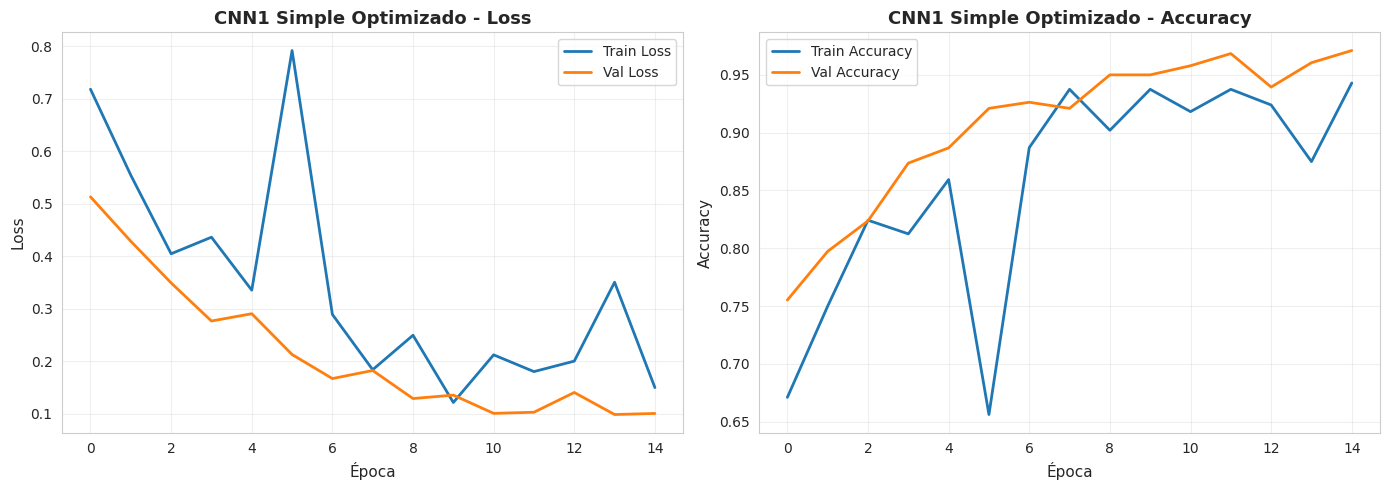

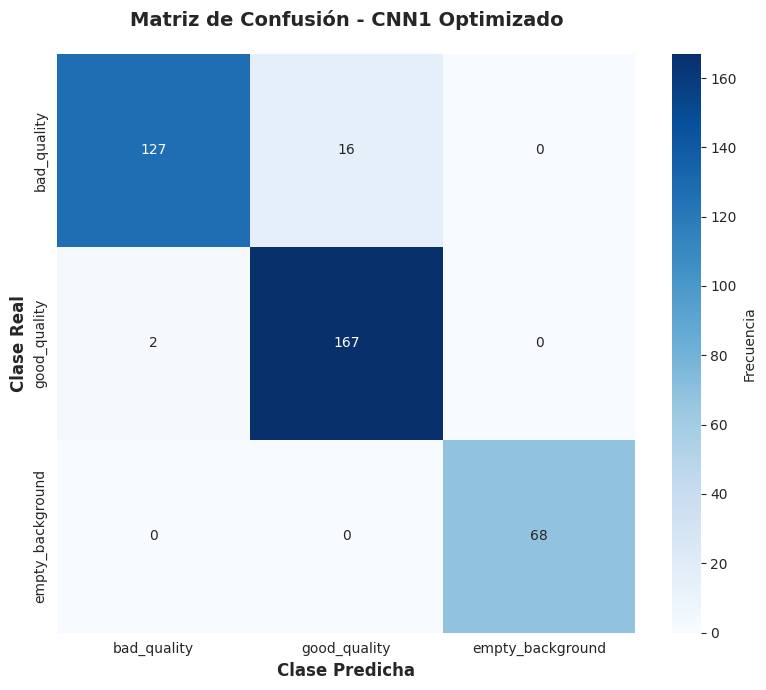

In [ ]:
# Evaluar CNN1 Optimizado
metrics_cnn1 = evaluate_model(
    cnn1,
    X_train, y_train_cat,
    X_val, y_val_cat,
    X_test, y_test_cat,
    "CNN1 Simple Optimizado"
)
plot_training_history(history_cnn1, "CNN1 Simple Optimizado")

# Matriz de confusión CNN1
y_pred_cnn1 = cnn1.predict(X_test, verbose=0)
y_pred_classes_cnn1 = np.argmax(y_pred_cnn1, axis=1)
y_true_cnn1 = y_test

cm_cnn1 = plot_confusion_matrix(y_true_cnn1, y_pred_classes_cnn1, clases, "CNN1 Optimizado")

# Agregar a tabla de resultados
results_table['Exp'].append(1)
results_table['Arquitectura'].append(f'Conv32→Conv64 + Dropout({best_hps_cnn1.get("dropout_rate"):.2f})')
results_table['Train_Acc'].append(f"{metrics_cnn1['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn1['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn1['test_acc']:.2f}")
results_table['Precision'].append(f"{metrics_cnn1['precision_macro']:.2f}")
results_table['Recall'].append(f"{metrics_cnn1['recall_macro']:.2f}")
results_table['F1_Score'].append(f"{metrics_cnn1['f1_macro']:.2f}")
results_table['Params'].append(cnn1.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn1:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn1['overfitting']:.2f}")

## 4.2 CNN 2: Arquitectura Intermedia con BN y Optimización

**Arquitectura Base:**
- 3 capas convolucionales (Conv32 → Conv64 → Conv128)
- Batch Normalization después de cada Conv
- Dropout estratégico en capas densas
- MaxPooling después de cada Conv

**Hiperparámetros a optimizar con Keras Tuner:**
- Learning rate
- Unidades en capas densas
- Dropout rate

### 4.2.1 Optimización de Hiperparámetros con Keras Tuner

In [ ]:
# Función de búsqueda para CNN2 con Keras Tuner
def build_cnn2_for_tuner(hp):
    # Hiperparámetros a optimizar
    dense_units_1 = hp.Choice('dense_units_1', values=[64, 128, 256])
    dense_units_2 = hp.Choice('dense_units_2', values=[32, 64, 128])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Construir modelo CNN2
    model = keras.models.Sequential([
        keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Arquitectura fija: 3 capas convolucionales + BN
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        keras.layers.BatchNormalization(name='bn1'),
        keras.layers.MaxPooling2D((2, 2), name='pool1'),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.BatchNormalization(name='bn2'),
        keras.layers.MaxPooling2D((2, 2), name='pool2'),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        keras.layers.BatchNormalization(name='bn3'),
        keras.layers.MaxPooling2D((2, 2), name='pool3'),

        # Capas densas optimizables
        keras.layers.Flatten(name='flatten'),
        keras.layers.Dropout(dropout_rate, name='dropout1'),
        keras.layers.Dense(dense_units_1, activation='relu', name='dense1'),
        keras.layers.Dropout(dropout_rate, name='dropout2'),
        keras.layers.Dense(dense_units_2, activation='relu', name='dense2'),
        keras.layers.Dense(len(clases), activation='softmax', name='output')
    ], name='CNN2_BN')

    # Compilar con learning rate optimizable
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" Función CNN2 para optimización definida")

✓ Función CNN2 para optimización definida


In [ ]:
# Configurar y ejecutar Keras Tuner para CNN2
print("="*70)
print("OPTIMIZACIÓN CNN2 - CONFIGURANDO KERAS TUNER")
print("="*70)

tuner_cnn2 = kt.Hyperband(
    build_cnn2_for_tuner,
    objective='val_accuracy',
    max_epochs=TUNER_MAX_EPOCHS,  # ← Controlado por FAST_RUN
    factor=3,
    directory='keras_tuner_cnn2',
    project_name='cnn2_optimization',
    overwrite=True
)

# Ejecutar búsqueda
print("\n" + "="*70)
print("INICIANDO BÚSQUEDA DE HIPERPARÁMETROS CNN2")
print("="*70)

search_generator_cnn2 = datagen_augmented.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, shuffle=True)

tuner_cnn2.search(
    search_generator_cnn2,
    validation_data=(X_val, y_val_cat),
    epochs=TUNER_SEARCH_EPOCHS,  # ← Controlado por FAST_RUN
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ClearTrainingOutput()],
    verbose=1
)

print("\n" + "="*70)
print("BÚSQUEDA CNN2 COMPLETADA")
print("="*70)

# Obtener mejores hiperparámetros
best_hps_cnn2 = tuner_cnn2.get_best_hyperparameters(num_trials=1)[0]

print("\n MEJORES HIPERPARÁMETROS CNN2:")
print("-" * 70)
print(f"Dense units 1: {best_hps_cnn2.get('dense_units_1')}")
print(f"Dense units 2: {best_hps_cnn2.get('dense_units_2')}")
print(f"Dropout rate: {best_hps_cnn2.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps_cnn2.get('learning_rate')}")
print("-" * 70)

Trial 10 Complete [00h 00m 54s]
val_accuracy: 0.9052631855010986

Best val_accuracy So Far: 0.9052631855010986
Total elapsed time: 00h 06m 50s

BÚSQUEDA CNN2 COMPLETADA

📊 MEJORES HIPERPARÁMETROS CNN2:
----------------------------------------------------------------------
Dense units 1: 128
Dense units 2: 32
Dropout rate: 0.10
Learning rate: 0.01
----------------------------------------------------------------------


### 4.2.2 Entrenamiento con Hiperparámetros Óptimos

In [ ]:
# Construir CNN2 con los mejores hiperparámetros usando el tuner
cnn2 = tuner_cnn2.hypermodel.build(best_hps_cnn2)

print(f"\n{'='*60}")
print(f"MODELO CNN2 CON HIPERPARÁMETROS OPTIMIZADOS")
print(f"{'='*60}")
cnn2.summary()
print(f"{'='*60}")
print(f"Dense units: [{best_hps_cnn2.get('dense_units_1')}, {best_hps_cnn2.get('dense_units_2')}]")
print(f"Dropout rate: {best_hps_cnn2.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps_cnn2.get('learning_rate')}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")

# Entrenar CNN2
print(f"\n{'='*60}")
print(f"ENTRENANDO CNN2 OPTIMIZADO")
print(f"{'='*60}")

train_generator_cnn2 = datagen_augmented.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, shuffle=True)

start_time_cnn2 = time.time()

history_cnn2 = cnn2.fit(
    train_generator_cnn2,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    verbose=1
)

end_time_cnn2 = time.time()
total_time_cnn2 = end_time_cnn2 - start_time_cnn2
time_per_epoch_cnn2 = total_time_cnn2 / EPOCHS

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN2 COMPLETADO")
print(f"{'='*60}")
print(f"Tiempo total: {total_time_cnn2:.2f} segundos ({total_time_cnn2/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn2:.2f} segundos")
print(f"{'='*60}")


MODELO CNN2 CON HIPERPARÁMETROS OPTIMIZADOS


Model: "CNN2_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,406,915 (20.63 MB)

 Trainable params: 5,406,467 (20.62 MB)

 Non-trainable params: 448 (1.75 KB)

Dense units: [128, 32]
Dropout rate: 0.10
Learning rate: 0.01
Timestamp: 2025-11-19 05:00:31

ENTRENANDO CNN2 OPTIMIZADO
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.6498 - loss: 22.5359 - val_accuracy: 0.4237 - val_loss: 41.6437
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8438 - loss: 1.6158 - val_accuracy: 0.4895 - val_loss: 36.5468
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.7966 - loss: 1.4322 - val_accuracy: 0.6289 - val_loss: 5.1874
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8750 - loss: 0.4414 - val_accuracy: 0.6368 - val_loss: 5.2751
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.8689 - loss: 0.3674 - val_accuracy: 0.8447 - val_loss: 0.4610
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.3646 - val_accuracy: 0.8658 - val_loss: 0.4183
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8785 - loss: 0.2961 - val_accuracy: 0.9237 - 


EVALUACIÓN: CNN2 + BN Optimizado
Train Accuracy: 79.02%
Val Accuracy: 80.26%
Test Accuracy: 80.53%
Precision (macro): 88.26%
Recall (macro): 80.99%
F1-Score (macro): 81.93%
Overfitting (Train - Val): -1.25%



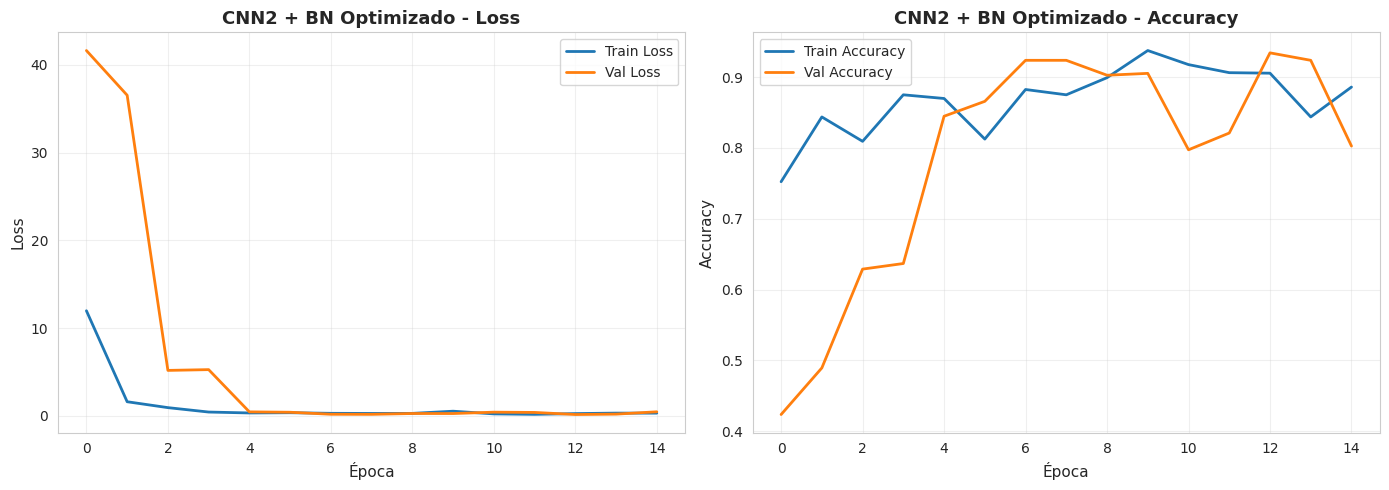

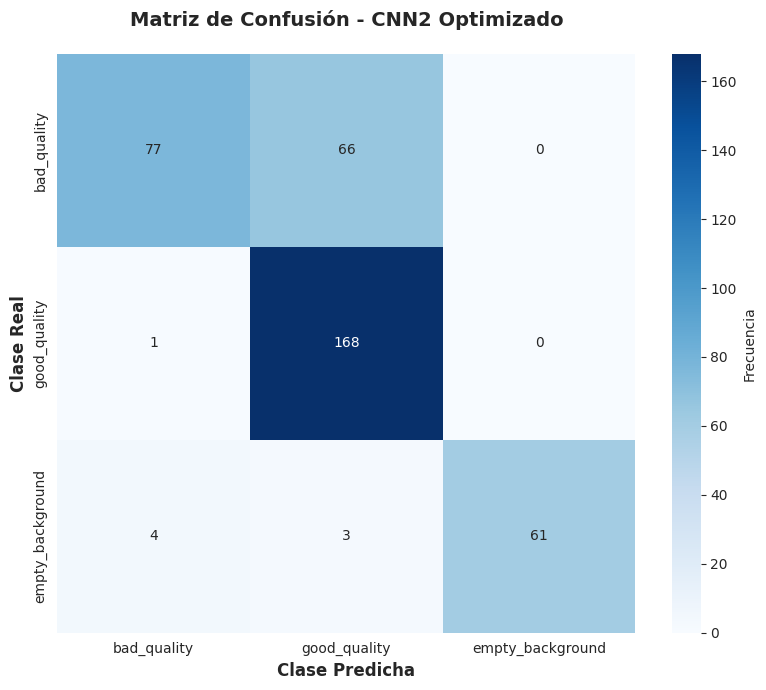

In [ ]:
# Evaluar CNN2 Optimizado
metrics_cnn2 = evaluate_model(
    cnn2,
    X_train, y_train_cat,
    X_val, y_val_cat,
    X_test, y_test_cat,
    "CNN2 + BN Optimizado"
)
plot_training_history(history_cnn2, "CNN2 + BN Optimizado")

# Matriz de confusión CNN2
y_pred_cnn2 = cnn2.predict(X_test, verbose=0)
y_pred_classes_cnn2 = np.argmax(y_pred_cnn2, axis=1)
y_true_cnn2 = y_test

cm_cnn2 = plot_confusion_matrix(y_true_cnn2, y_pred_classes_cnn2, clases, "CNN2 Optimizado")

# Agregar a tabla de resultados
results_table['Exp'].append(2)
results_table['Arquitectura'].append(f'Conv32→64→128 + BN + Dropout({best_hps_cnn2.get("dropout_rate"):.2f})')
results_table['Train_Acc'].append(f"{metrics_cnn2['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn2['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn2['test_acc']:.2f}")
results_table['Precision'].append(f"{metrics_cnn2['precision_macro']:.2f}")
results_table['Recall'].append(f"{metrics_cnn2['recall_macro']:.2f}")
results_table['F1_Score'].append(f"{metrics_cnn2['f1_macro']:.2f}")
results_table['Params'].append(cnn2.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn2:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn2['overfitting']:.2f}")

## 4.3 CNN 3: Arquitectura Avanzada con Callbacks y Optimización

**Arquitectura Base:**
- 4 capas convolucionales (Conv32 → Conv64 → Conv128 → Conv256)
- Batch Normalization después de cada Conv
- Dropout después de cada bloque convolucional y en capas densas
- MaxPooling después de cada Conv

**Hiperparámetros a optimizar con Keras Tuner:**
- Learning rate
- Unidades en capas densas
- Dropout rate

### 4.3.1 Optimización de Hiperparámetros con Keras Tuner

In [ ]:
# Función de búsqueda para CNN3 con Keras Tuner
def build_cnn3_for_tuner(hp):
    # Hiperparámetros a optimizar
    dense_units_1 = hp.Choice('dense_units_1', values=[128, 256, 512])
    dense_units_2 = hp.Choice('dense_units_2', values=[64, 128, 256])
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.05)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Construir modelo CNN3
    model = keras.models.Sequential([
        keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Arquitectura fija: 4 capas convolucionales + BN + Dropout
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
        keras.layers.BatchNormalization(name='bn1'),
        keras.layers.MaxPooling2D((2, 2), name='pool1'),
        keras.layers.Dropout(dropout_rate, name='dropout1'),

        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.BatchNormalization(name='bn2'),
        keras.layers.MaxPooling2D((2, 2), name='pool2'),
        keras.layers.Dropout(dropout_rate, name='dropout2'),

        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
        keras.layers.BatchNormalization(name='bn3'),
        keras.layers.MaxPooling2D((2, 2), name='pool3'),
        keras.layers.Dropout(dropout_rate, name='dropout3'),

        keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'),
        keras.layers.BatchNormalization(name='bn4'),
        keras.layers.MaxPooling2D((2, 2), name='pool4'),
        keras.layers.Dropout(dropout_rate, name='dropout4'),

        # Capas densas optimizables
        keras.layers.Flatten(name='flatten'),
        keras.layers.Dense(dense_units_1, activation='relu', name='dense1'),
        keras.layers.Dropout(dropout_rate, name='dropout5'),
        keras.layers.Dense(dense_units_2, activation='relu', name='dense2'),
        keras.layers.Dropout(dropout_rate, name='dropout6'),
        keras.layers.Dense(len(clases), activation='softmax', name='output')
    ], name='CNN3_Advanced')

    # Compilar con learning rate optimizable
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print(" Función CNN3 para optimización definida")

✓ Función CNN3 para optimización definida


In [ ]:
# Configurar y ejecutar Keras Tuner para CNN3
print("="*70)
print("OPTIMIZACIÓN CNN3 - CONFIGURANDO KERAS TUNER")
print("="*70)

tuner_cnn3 = kt.Hyperband(
    build_cnn3_for_tuner,
    objective='val_accuracy',
    max_epochs=TUNER_MAX_EPOCHS,  # ← Controlado por FAST_RUN
    factor=3,
    directory='keras_tuner_cnn3',
    project_name='cnn3_optimization',
    overwrite=True
)

# Ejecutar búsqueda
print("\n" + "="*70)
print("INICIANDO BÚSQUEDA DE HIPERPARÁMETROS CNN3")
print("="*70)

search_generator_cnn3 = datagen_augmented.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, shuffle=True)

tuner_cnn3.search(
    search_generator_cnn3,
    validation_data=(X_val, y_val_cat),
    epochs=TUNER_SEARCH_EPOCHS,  # ← Controlado por FAST_RUN
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ClearTrainingOutput()],
    verbose=1
)

print("\n" + "="*70)
print("BÚSQUEDA CNN3 COMPLETADA")
print("="*70)

# Obtener mejores hiperparámetros
best_hps_cnn3 = tuner_cnn3.get_best_hyperparameters(num_trials=1)[0]

print("\n MEJORES HIPERPARÁMETROS CNN3:")
print("-" * 70)
print(f"Dense units 1: {best_hps_cnn3.get('dense_units_1')}")
print(f"Dense units 2: {best_hps_cnn3.get('dense_units_2')}")
print(f"Dropout rate: {best_hps_cnn3.get('dropout_rate'):.2f}")
print(f"Learning rate: {best_hps_cnn3.get('learning_rate')}")
print("-" * 70)

Trial 10 Complete [00h 00m 42s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.800000011920929
Total elapsed time: 00h 07m 56s

BÚSQUEDA CNN3 COMPLETADA

📊 MEJORES HIPERPARÁMETROS CNN3:
----------------------------------------------------------------------
Dense units 1: 128
Dense units 2: 64
Dropout rate: 0.20
Learning rate: 0.01
----------------------------------------------------------------------


### 4.3.2 Entrenamiento con Hiperparámetros Óptimos y Callbacks Avanzados

In [ ]:
# Construir CNN3 con los mejores hiperparámetros usando el tuner
cnn3 = tuner_cnn3.hypermodel.build(best_hps_cnn3)

print(f"\n{'='*60}")
print(f"MODELO CNN3 CON HIPERPARÁMETROS OPTIMIZADOS")
print(f"{'='*60}")
cnn3.summary()
print(f"{'='*60}")
print(f"Dense units: [{best_hps_cnn3.get('dense_units_1')}, {best_hps_cnn3.get('dense_units_2')}]")
print(f"Dropout rate: {best_hps_cnn3.get('dropout_rate'):.2f} (en todos los bloques)")
print(f"Learning rate inicial: {best_hps_cnn3.get('learning_rate')}")
print(f"Callbacks: EarlyStopping + ReduceLROnPlateau")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*60}")


MODELO CNN3 CON HIPERPARÁMETROS OPTIMIZADOS


Model: "CNN3_Advanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 150, 150, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 75, 75, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 37, 37, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 18, 18, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout5 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout6 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,053,123 (11.65 MB)

 Trainable params: 3,052,163 (11.64 MB)

 Non-trainable params: 960 (3.75 KB)

Dense units: [128, 64]
Dropout rate: 0.20 (en todos los bloques)
Learning rate inicial: 0.01
Callbacks: EarlyStopping + ReduceLROnPlateau
Timestamp: 2025-11-19 05:10:03


In [ ]:
# Entrenar CNN3 con callbacks avanzados
print(f"\n{'='*60}")
print(f"ENTRENANDO CNN3 OPTIMIZADO CON CALLBACKS AVANZADOS")
print(f"{'='*60}")

# Callbacks avanzados para CNN3
callbacks_cnn3 = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

train_generator_cnn3 = datagen_augmented.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, shuffle=True)

start_time_cnn3 = time.time()

history_cnn3 = cnn3.fit(
    train_generator_cnn3,
    validation_data=(X_val, y_val_cat),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=callbacks_cnn3,
    verbose=1
)

end_time_cnn3 = time.time()
total_time_cnn3 = end_time_cnn3 - start_time_cnn3
epochs_trained_cnn3 = len(history_cnn3.history['loss'])
time_per_epoch_cnn3 = total_time_cnn3 / epochs_trained_cnn3

print(f"\n{'='*60}")
print(f"ENTRENAMIENTO CNN3 COMPLETADO")
print(f"{'='*60}")
print(f"Épocas entrenadas: {epochs_trained_cnn3} (de {EPOCHS} máximas)")
print(f"Tiempo total: {total_time_cnn3:.2f} segundos ({total_time_cnn3/60:.2f} minutos)")
print(f"Tiempo por época: {time_per_epoch_cnn3:.2f} segundos")
if epochs_trained_cnn3 < EPOCHS:
    print(f"  Early Stopping activado en época {epochs_trained_cnn3}")
print(f"{'='*60}")


ENTRENANDO CNN3 OPTIMIZADO CON CALLBACKS AVANZADOS
Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 365ms/step - accuracy: 0.6266 - loss: 10.6794 - val_accuracy: 0.4132 - val_loss: 26.7542 - learning_rate: 0.0100
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7500 - loss: 0.7627 - val_accuracy: 0.4421 - val_loss: 24.6772 - learning_rate: 0.0100
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7527 - loss: 0.7225 - val_accuracy: 0.4553 - val_loss: 13.7084 - learning_rate: 0.0100
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7188 - loss: 0.9943 - val_accuracy: 0.4605 - val_loss: 12.4133 - learning_rate: 0.0100
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.7936 - loss: 0.5377 - val_accuracy: 0.6237 - val_loss: 12.4772 - learning_rate: 0.0100
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6875 - loss: 0.4992 - val_accuracy: 0.6658 - val_loss: 12.2193 - learning_rate: 0.0100
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━


EVALUACIÓN: CNN3 Avanzada Optimizada
Train Accuracy: 93.95%
Val Accuracy: 93.68%
Test Accuracy: 95.00%
Precision (macro): 96.07%
Recall (macro): 95.79%
F1-Score (macro): 95.89%
Overfitting (Train - Val): 0.26%



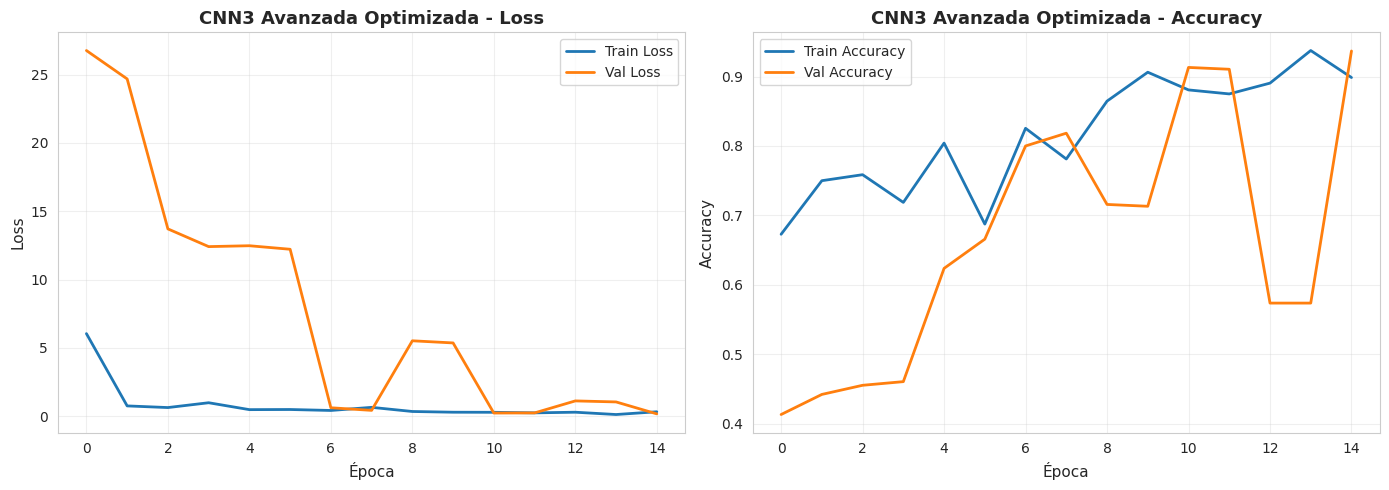

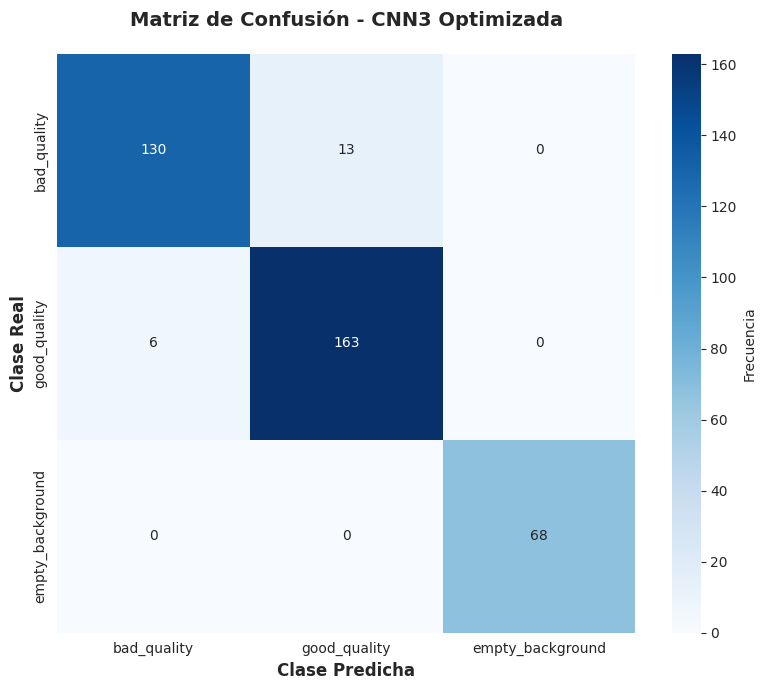

In [ ]:
# Evaluar CNN3 Optimizado
metrics_cnn3 = evaluate_model(
    cnn3,
    X_train, y_train_cat,
    X_val, y_val_cat,
    X_test, y_test_cat,
    "CNN3 Avanzada Optimizada"
)
plot_training_history(history_cnn3, "CNN3 Avanzada Optimizada")

# Matriz de confusión CNN3
y_pred_cnn3 = cnn3.predict(X_test, verbose=0)
y_pred_classes_cnn3 = np.argmax(y_pred_cnn3, axis=1)
y_true_cnn3 = y_test

cm_cnn3 = plot_confusion_matrix(y_true_cnn3, y_pred_classes_cnn3, clases, "CNN3 Optimizada")

# Agregar a tabla de resultados
results_table['Exp'].append(3)
results_table['Arquitectura'].append(f'Conv32→64→128→256 + BN + Dropout({best_hps_cnn3.get("dropout_rate"):.2f}) + ES+LR')
results_table['Train_Acc'].append(f"{metrics_cnn3['train_acc']:.2f}")
results_table['Val_Acc'].append(f"{metrics_cnn3['val_acc']:.2f}")
results_table['Test_Acc'].append(f"{metrics_cnn3['test_acc']:.2f}")
results_table['Precision'].append(f"{metrics_cnn3['precision_macro']:.2f}")
results_table['Recall'].append(f"{metrics_cnn3['recall_macro']:.2f}")
results_table['F1_Score'].append(f"{metrics_cnn3['f1_macro']:.2f}")
results_table['Params'].append(cnn3.count_params())
results_table['Time_per_Epoch'].append(f"{time_per_epoch_cnn3:.2f}")
results_table['Overfitting'].append(f"{metrics_cnn3['overfitting']:.2f}")

---
### Tabla Comparativa de Resultados

In [ ]:
df_results = pd.DataFrame(results_table)

print("\n" + "="*120)
print(" "*40 + "TABLA COMPARATIVA DE RESULTADOS")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)
print("\nNotas:")
print("  • Overfitting = Train_Acc - Val_Acc")
print("  • BN = Batch Normalization")
print("  • ES = Early Stopping")
print("  • LR = Learning Rate Scheduling")
print("="*120)


                                        TABLA COMPARATIVA DE RESULTADOS
 Exp                                                Arquitectura Train_Acc Val_Acc Test_Acc Precision Recall F1_Score   Params Time_per_Epoch Overfitting
   0                                                MLP-Baseline     98.64   96.84    96.58     97.22  97.18    97.20  8648579           1.54        1.80
   1                  Conv32→Conv64 + Dropout(0.15) [Optimizado]     96.44   97.11    95.26     96.57  95.88    96.09 11242819           5.85       -0.67
   2             Conv32→64→128 + BN + Dropout(0.10) [Optimizado]     79.02   80.26    80.53     88.26  80.99    81.93  5406915           6.01       -1.25
   3 Conv32→64→128→256 + BN + Dropout(0.20) + ES+LR [Optimizado]     93.95   93.68    95.00     96.07  95.79    95.89  3053123           7.62        0.26

Notas:
  • Overfitting = Train_Acc - Val_Acc
  • BN = Batch Normalization
  • ES = Early Stopping
  • LR = Learning Rate Scheduling


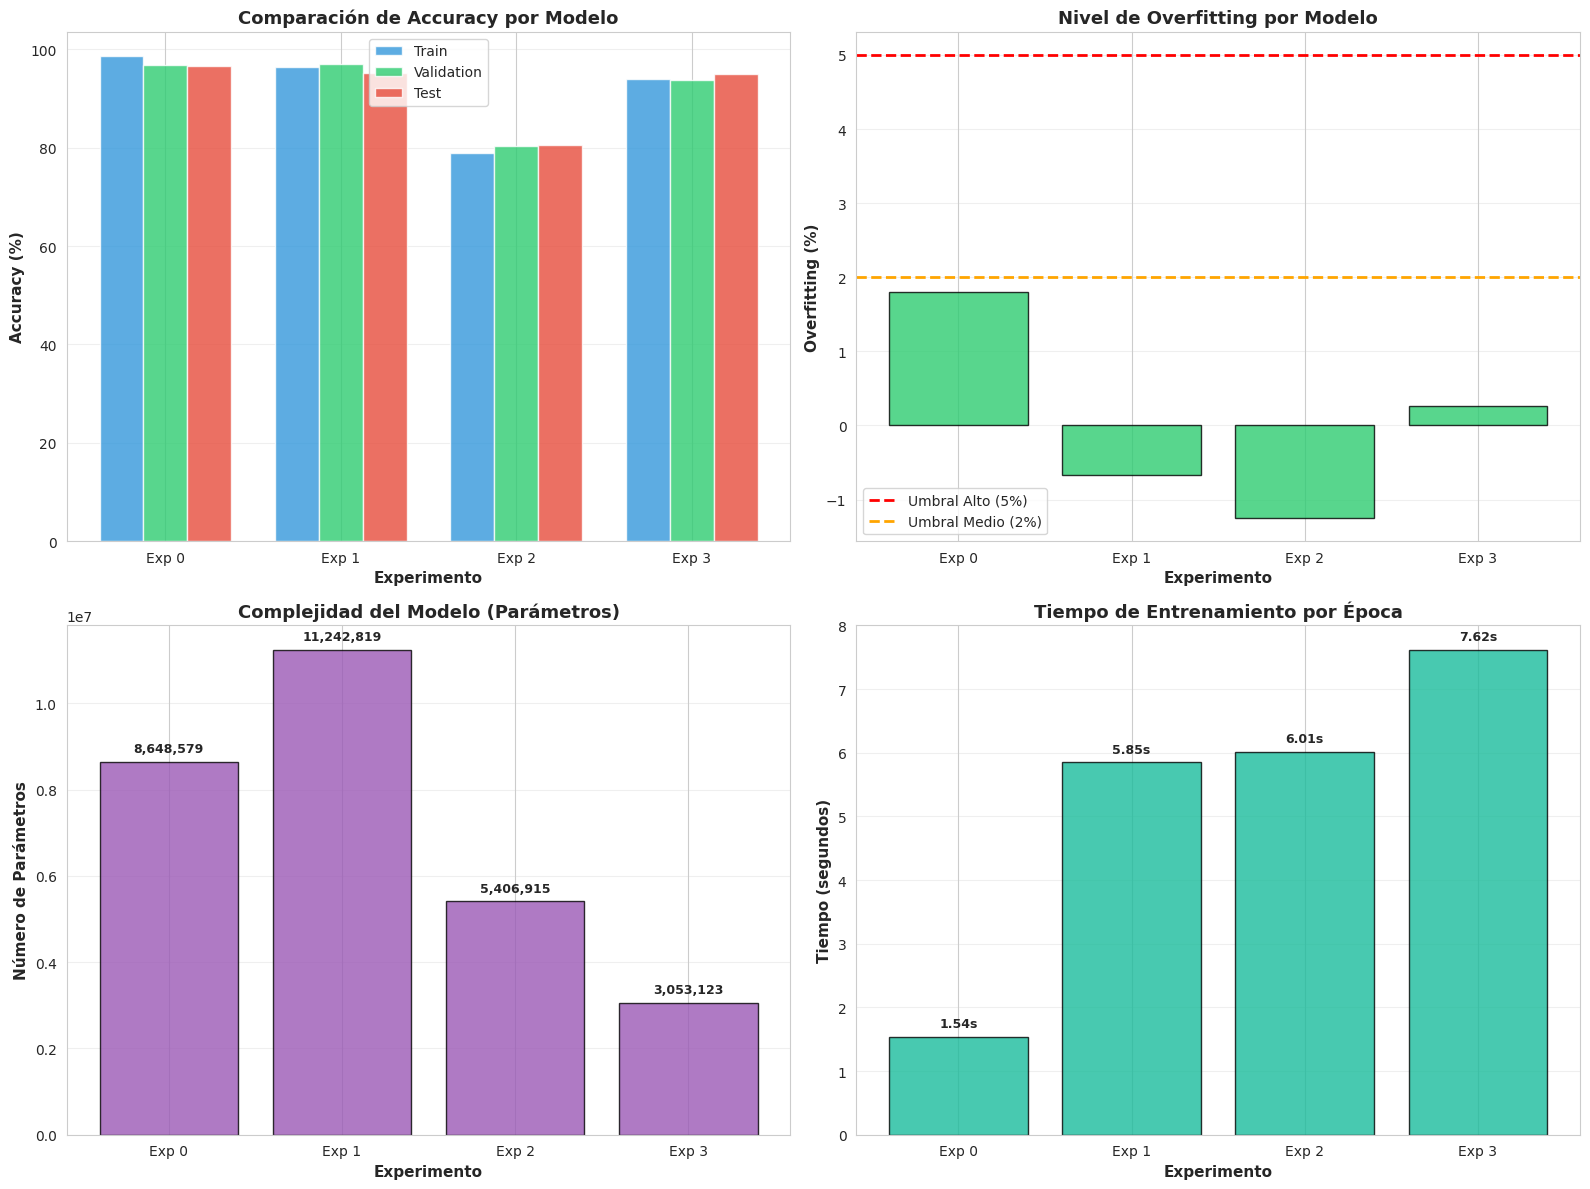

In [ ]:
# Visualización gráfica de comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Comparación de Accuracy
ax1 = axes[0, 0]
x = df_results['Exp']
width = 0.25
x_pos = np.arange(len(x))

train_accs = [float(acc) for acc in df_results['Train_Acc']]
val_accs = [float(acc) for acc in df_results['Val_Acc']]
test_accs = [float(acc) for acc in df_results['Test_Acc']]

ax1.bar(x_pos - width, train_accs, width, label='Train', color='#3498db', alpha=0.8)
ax1.bar(x_pos, val_accs, width, label='Validation', color='#2ecc71', alpha=0.8)
ax1.bar(x_pos + width, test_accs, width, label='Test', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax1.set_ylabel('Accuracy (%)', fontweight='bold', fontsize=11)
ax1.set_title('Comparación de Accuracy por Modelo', fontweight='bold', fontsize=13)
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"Exp {i}" for i in x])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Overfitting
ax2 = axes[0, 1]
overfitting_vals = [float(ov) for ov in df_results['Overfitting']]
colors_ov = ['#e74c3c' if ov > 5 else '#f39c12' if ov > 2 else '#2ecc71' for ov in overfitting_vals]
ax2.bar(x_pos, overfitting_vals, color=colors_ov, alpha=0.8, edgecolor='black')
ax2.axhline(y=5, color='red', linestyle='--', linewidth=2, label='Umbral Alto (5%)')
ax2.axhline(y=2, color='orange', linestyle='--', linewidth=2, label='Umbral Medio (2%)')
ax2.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax2.set_ylabel('Overfitting (%)', fontweight='bold', fontsize=11)
ax2.set_title('Nivel de Overfitting por Modelo', fontweight='bold', fontsize=13)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"Exp {i}" for i in x])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Número de Parámetros
ax3 = axes[1, 0]
params = df_results['Params']
ax3.bar(x_pos, params, color='#9b59b6', alpha=0.8, edgecolor='black')
ax3.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax3.set_ylabel('Número de Parámetros', fontweight='bold', fontsize=11)
ax3.set_title('Complejidad del Modelo (Parámetros)', fontweight='bold', fontsize=13)
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f"Exp {i}" for i in x])
ax3.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(params):
    ax3.text(i, v + max(params)*0.02, f'{v:,}', ha='center', fontsize=9, fontweight='bold')

# 4. Tiempo por Época
ax4 = axes[1, 1]
times = [float(t) for t in df_results['Time_per_Epoch']]
ax4.bar(x_pos, times, color='#1abc9c', alpha=0.8, edgecolor='black')
ax4.set_xlabel('Experimento', fontweight='bold', fontsize=11)
ax4.set_ylabel('Tiempo (segundos)', fontweight='bold', fontsize=11)
ax4.set_title('Tiempo de Entrenamiento por Época', fontweight='bold', fontsize=13)
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f"Exp {i}" for i in x])
ax4.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(times):
    ax4.text(i, v + max(times)*0.02, f'{v:.2f}s', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 4.4 Comparación Final: MLP Baseline vs Mejor CNN

En esta sección se compara el modelo baseline MLP con la mejor arquitectura CNN encontrada, evaluando mejoras absolutas y relativas en métricas clave.

In [ ]:
# Identificar la mejor CNN basada en Test Accuracy
print("\n" + "="*80)
print("IDENTIFICANDO MEJOR MODELO CNN")
print("="*80)

# Extraer métricas de CNNs (Exp 1, 2, 3)
cnn_experiments = df_results[df_results['Exp'] > 0].copy()
cnn_experiments['Test_Acc_Float'] = cnn_experiments['Test_Acc'].astype(float)

# Encontrar el índice de la mejor CNN
best_cnn_idx = cnn_experiments['Test_Acc_Float'].idxmax()
best_cnn = cnn_experiments.loc[best_cnn_idx]

print(f"\n MEJOR CNN IDENTIFICADA:")
print(f"   Experimento: {int(best_cnn['Exp'])}")
print(f"   Arquitectura: {best_cnn['Arquitectura']}")
print(f"   Test Accuracy: {best_cnn['Test_Acc']}%")
print("="*80)


IDENTIFICANDO MEJOR MODELO CNN

🏆 MEJOR CNN IDENTIFICADA:
   Experimento: 1
   Arquitectura: Conv32→Conv64 + Dropout(0.15) [Optimizado]
   Test Accuracy: 95.26%


In [ ]:
# Extraer métricas del MLP Baseline y Mejor CNN
mlp_metrics = df_results[df_results['Exp'] == 0].iloc[0]
best_cnn_metrics = best_cnn

# Calcular mejoras
def calculate_improvement(mlp_val, cnn_val):
    """Calcula mejora absoluta y relativa"""
    mlp_float = float(mlp_val)
    cnn_float = float(cnn_val)
    mejora_abs = cnn_float - mlp_float
    mejora_rel = ((cnn_float - mlp_float) / mlp_float) * 100 if mlp_float != 0 else 0
    return mejora_abs, mejora_rel

# Crear tabla de comparación
comparison_data = {
    'Métrica': [
        'Test Accuracy (%)',
        'Precision (macro) (%)',
        'Recall (macro) (%)',
        'F1-Score (macro) (%)',
        'Parámetros totales',
        'Tiempo entrenamiento (seg)'
    ],
    'MLP Baseline': [
        mlp_metrics['Test_Acc'],
        mlp_metrics['Precision'],
        mlp_metrics['Recall'],
        mlp_metrics['F1_Score'],
        f"{mlp_metrics['Params']:,}",
        mlp_metrics['Time_per_Epoch']
    ],
    'Mejor CNN': [
        best_cnn_metrics['Test_Acc'],
        best_cnn_metrics['Precision'],
        best_cnn_metrics['Recall'],
        best_cnn_metrics['F1_Score'],
        f"{best_cnn_metrics['Params']:,}",
        best_cnn_metrics['Time_per_Epoch']
    ]
}

# Calcular mejoras para métricas numéricas
mejoras_absolutas = []
mejoras_relativas = []

for metric in ['Test_Acc', 'Precision', 'Recall', 'F1_Score']:
    abs_imp, rel_imp = calculate_improvement(mlp_metrics[metric], best_cnn_metrics[metric])
    mejoras_absolutas.append(f"{abs_imp:+.2f}")
    mejoras_relativas.append(f"{rel_imp:+.2f}%")

# Params y Time no aplican para mejora relativa de la misma forma
mejoras_absolutas.append('N/A')
mejoras_relativas.append('N/A')
mejoras_absolutas.append('N/A')
mejoras_relativas.append('N/A')

comparison_data['Mejora Absoluta'] = mejoras_absolutas
comparison_data['Mejora Relativa (%)'] = mejoras_relativas

df_comparison = pd.DataFrame(comparison_data)

# Mostrar tabla
print("\n" + "="*120)
print(" "*35 + "TABLA COMPARATIVA: MLP vs MEJOR CNN")
print("="*120)
print(df_comparison.to_string(index=False))
print("="*120)


                                   TABLA COMPARATIVA: MLP vs MEJOR CNN
                   Métrica MLP Baseline  Mejor CNN Mejora Absoluta Mejora Relativa (%)
         Test Accuracy (%)        96.58      95.26           -1.32              -1.37%
     Precision (macro) (%)        97.22      96.57           -0.65              -0.67%
        Recall (macro) (%)        97.18      95.88           -1.30              -1.34%
      F1-Score (macro) (%)        97.20      96.09           -1.11              -1.14%
        Parámetros totales    8,648,579 11,242,819             N/A                 N/A
Tiempo entrenamiento (seg)         1.54       5.85             N/A                 N/A

📊 RESUMEN DE MEJORAS:
   • Test Accuracy: -1.32 puntos (-1.37% mejora relativa)
   • Precision: -0.65 puntos (-0.67% mejora relativa)
   • Recall: -1.30 puntos (-1.34% mejora relativa)
   • F1-Score: -1.11 puntos (-1.14% mejora relativa)
   • Complejidad: 11,242,819 parámetros (vs 8,648,579 en MLP)



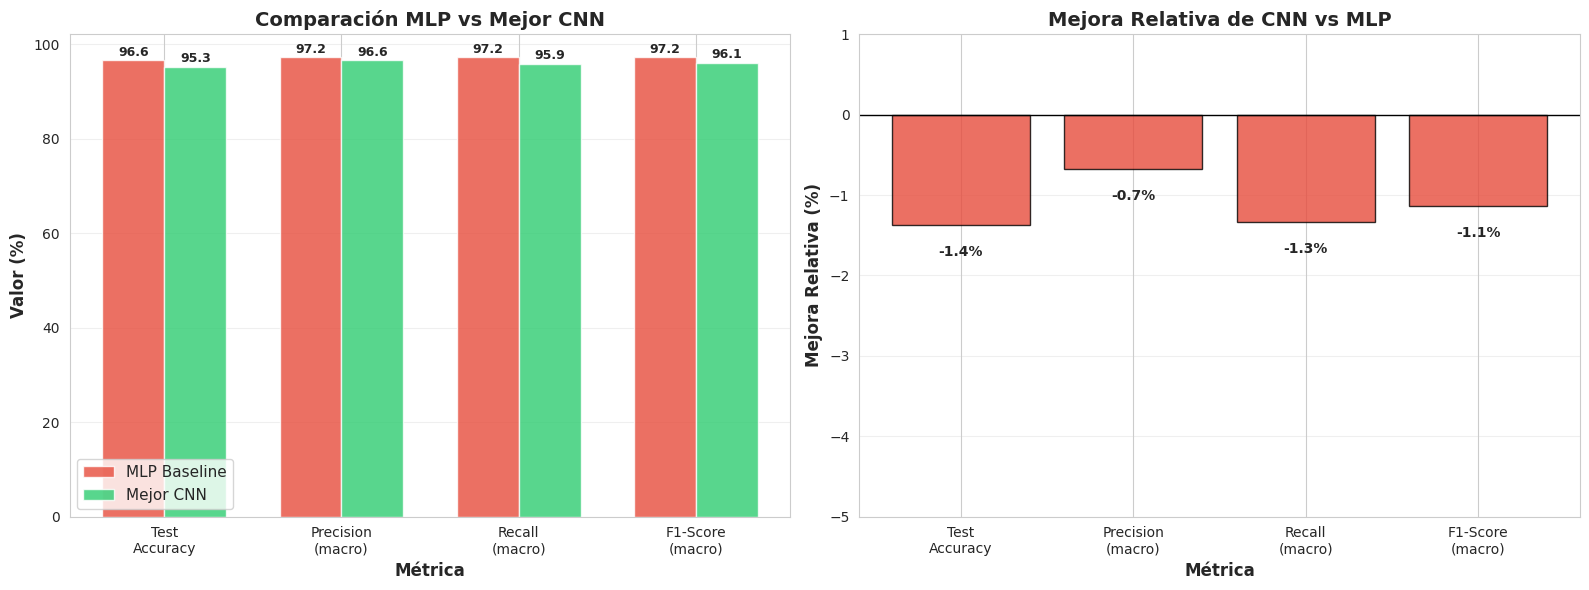

In [ ]:
# Visualización gráfica de la comparación MLP vs Mejor CNN
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparación de métricas principales
ax1 = axes[0]
metrics_names = ['Test\nAccuracy', 'Precision\n(macro)', 'Recall\n(macro)', 'F1-Score\n(macro)']
mlp_values = [float(mlp_metrics['Test_Acc']), float(mlp_metrics['Precision']),
              float(mlp_metrics['Recall']), float(mlp_metrics['F1_Score'])]
cnn_values = [float(best_cnn_metrics['Test_Acc']), float(best_cnn_metrics['Precision']),
              float(best_cnn_metrics['Recall']), float(best_cnn_metrics['F1_Score'])]

x_pos = np.arange(len(metrics_names))
width = 0.35

ax1.bar(x_pos - width/2, mlp_values, width, label='MLP Baseline', color='#e74c3c', alpha=0.8)
ax1.bar(x_pos + width/2, cnn_values, width, label='Mejor CNN', color='#2ecc71', alpha=0.8)

ax1.set_xlabel('Métrica', fontweight='bold', fontsize=12)
ax1.set_ylabel('Valor (%)', fontweight='bold', fontsize=12)
ax1.set_title('Comparación MLP vs Mejor CNN', fontweight='bold', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(metrics_names)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Añadir valores en las barras
for i, (mlp_val, cnn_val) in enumerate(zip(mlp_values, cnn_values)):
    ax1.text(i - width/2, mlp_val + 1, f'{mlp_val:.1f}', ha='center', fontsize=9, fontweight='bold')
    ax1.text(i + width/2, cnn_val + 1, f'{cnn_val:.1f}', ha='center', fontsize=9, fontweight='bold')

# Gráfico 2: Mejora Relativa
ax2 = axes[1]
mejoras_rel_values = [float(m.rstrip('%')) for m in mejoras_relativas[:4]]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in mejoras_rel_values]

ax2.bar(x_pos, mejoras_rel_values, color=colors, alpha=0.8, edgecolor='black')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.set_xlabel('Métrica', fontweight='bold', fontsize=12)
ax2.set_ylabel('Mejora Relativa (%)', fontweight='bold', fontsize=12)
ax2.set_title('Mejora Relativa de CNN vs MLP', fontweight='bold', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(metrics_names)
ax2.grid(axis='y', alpha=0.3)

# asegurar que mejoras_rel_values ya es una lista de floats
mejoras_rel_values = [float(m.rstrip('%')) for m in mejoras_relativas[:4]]

# ajustar límites Y para dejar espacio para las etiquetas
ymin = min(min(mejoras_rel_values) - 1.0, -5.0)
ymax = max(max(mejoras_rel_values) + 1.0, 1.0)
ax2.set_ylim(ymin, ymax)

# añadir valores con alineación vertical dependiente del signo
for i, val in enumerate(mejoras_rel_values):
    # desplazamiento pequeño en unidades del eje (por ejemplo 0.2 ó -0.2)
    offset = 0.25 if val > 0 else -0.25
    va = 'bottom' if val > 0 else 'top'
    ax2.text(i, val + offset, f'{val:+.1f}%', ha='center', va=va,
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show();

---
## 4.3 Análisis y Justificación

En esta sección se analiza en profundidad la selección del mejor modelo, el impacto de las técnicas implementadas, los errores más comunes y las limitaciones identificadas.

### 4.3.1 Selección de Arquitectura Final

In [ ]:
# a) Selección de arquitectura final y justificación
print("\n" + "="*100)
print(" "*35 + "4.3.1 SELECCIÓN DE ARQUITECTURA FINAL")
print("="*100)

# Identificar la mejor arquitectura basada en val_acc
cnn_models = df_results[df_results['Exp'] > 0].copy()
cnn_models['Val_Acc_Float'] = cnn_models['Val_Acc'].astype(float)
cnn_models['Test_Acc_Float'] = cnn_models['Test_Acc'].astype(float)

best_model_idx = cnn_models['Val_Acc_Float'].idxmax()
best_model = cnn_models.loc[best_model_idx]

print(f"\n ARQUITECTURA SELECCIONADA COMO FINAL:")
print(f"   Experimento: {int(best_model['Exp'])}")
print(f"   Arquitectura: {best_model['Arquitectura']}")
print(f"   Validation Accuracy: {best_model['Val_Acc']}%")
print(f"   Test Accuracy: {best_model['Test_Acc']}%")

# Comparar val_acc con otras arquitecturas (diferencias numéricas)
print(f"\n COMPARACIÓN CON OTRAS ARQUITECTURAS (Validation Accuracy):")
print("-" * 100)
for idx, row in cnn_models.iterrows():
    diff = row['Val_Acc_Float'] - best_model['Val_Acc_Float']
    exp_num = int(row['Exp'])
    if diff == 0:
        print(f"   CNN{exp_num}: {row['Val_Acc']}% ← SELECCIONADA")
    else:
        print(f"   CNN{exp_num}: {row['Val_Acc']}% (diferencia: {diff:+.2f}%)")

# Calcular eficiencia: val_acc / (parámetros / 1,000,000)
print(f"\n ANÁLISIS DE EFICIENCIA: val_acc / (params / 1M)")
print("-" * 100)
efficiency_data = []
for idx, row in cnn_models.iterrows():
    exp_num = int(row['Exp'])
    val_acc = row['Val_Acc_Float']
    params = row['Params']
    efficiency = val_acc / (params / 1_000_000)
    efficiency_data.append({
        'CNN': f'CNN{exp_num}',
        'Val_Acc': val_acc,
        'Params': params,
        'Params_M': params / 1_000_000,
        'Efficiency': efficiency
    })
    marker = "  MÁS EFICIENTE" if efficiency == max([e['Efficiency'] for e in efficiency_data]) and idx == cnn_models.index[-1] else ""
    print(f"   CNN{exp_num}: {efficiency:.2f} (val_acc: {val_acc:.2f}% / params: {params:,}){marker}")

# Determinar cuál es más eficiente
most_efficient = max(efficiency_data, key=lambda x: x['Efficiency'])
print(f"\n Modelo más eficiente: {most_efficient['CNN']} con eficiencia de {most_efficient['Efficiency']:.2f}")


                                   4.3.1 SELECCIÓN DE ARQUITECTURA FINAL

🏆 ARQUITECTURA SELECCIONADA COMO FINAL:
   Experimento: 1
   Arquitectura: Conv32→Conv64 + Dropout(0.15) [Optimizado]
   Validation Accuracy: 97.11%
   Test Accuracy: 95.26%

📊 COMPARACIÓN CON OTRAS ARQUITECTURAS (Validation Accuracy):
----------------------------------------------------------------------------------------------------
   CNN1: 97.11% ← SELECCIONADA
   CNN2: 80.26% (diferencia: -16.85%)
   CNN3: 93.68% (diferencia: -3.43%)

⚡ ANÁLISIS DE EFICIENCIA: val_acc / (params / 1M)
----------------------------------------------------------------------------------------------------
   CNN1: 8.64 (val_acc: 97.11% / params: 11,242,819)
   CNN2: 14.84 (val_acc: 80.26% / params: 5,406,915)
   CNN3: 30.68 (val_acc: 93.68% / params: 3,053,123) ⭐ MÁS EFICIENTE

✅ Modelo más eficiente: CNN3 con eficiencia de 30.68

📝 JUSTIFICACIÓN:
-----------------------------------------------------------------------------------

### 4.3.2 Impacto de Técnicas de Regularización (0.15 pts)

In [ ]:
# b) Impacto de técnicas - Comparar arquitecturas con/sin Batch Normalization
print("\n" + "="*100)
print(" "*30 + "4.3.2 IMPACTO DE BATCH NORMALIZATION")
print("="*100)

# Comparar CNN1 (sin BN) vs CNN2 (con BN)
cnn1_data = df_results[df_results['Exp'] == 1].iloc[0]
cnn2_data = df_results[df_results['Exp'] == 2].iloc[0]

print(f"\n COMPARACIÓN: CNN1 (sin BN) vs CNN2 (con BN)")
print("-" * 100)
print(f"   CNN1 (sin BN):")
print(f"      - Val Accuracy: {cnn1_data['Val_Acc']}%")
print(f"      - Test Accuracy: {cnn1_data['Test_Acc']}%")
print(f"      - Overfitting: {cnn1_data['Overfitting']}%")
print(f"\n   CNN2 (con BN):")
print(f"      - Val Accuracy: {cnn2_data['Val_Acc']}%")
print(f"      - Test Accuracy: {cnn2_data['Test_Acc']}%")
print(f"      - Overfitting: {cnn2_data['Overfitting']}%")

# Calcular reducción en overfitting
overfitting_sin_bn = float(cnn1_data['Overfitting'])
overfitting_con_bn = float(cnn2_data['Overfitting'])
reduccion_overfitting = overfitting_sin_bn - overfitting_con_bn

print(f"\n REDUCCIÓN EN OVERFITTING:")
print("-" * 100)
print(f"   Overfitting sin BN (CNN1): {overfitting_sin_bn:.2f}%")
print(f"   Overfitting con BN (CNN2): {overfitting_con_bn:.2f}%")
print(f"   Reducción: {reduccion_overfitting:+.2f} puntos porcentuales")

if reduccion_overfitting > 0:
    print(f"  Batch Normalization REDUJO el overfitting en {reduccion_overfitting:.2f}%")
else:
    print(f"  Batch Normalization AUMENTÓ el overfitting en {abs(reduccion_overfitting):.2f}%")

# Mejora en accuracy
mejora_val_acc = float(cnn2_data['Val_Acc']) - float(cnn1_data['Val_Acc'])
mejora_test_acc = float(cnn2_data['Test_Acc']) - float(cnn1_data['Test_Acc'])

print(f"\n MEJORA EN ACCURACY:")
print("-" * 100)
print(f"   Val Accuracy: {mejora_val_acc:+.2f}%")
print(f"   Test Accuracy: {mejora_test_acc:+.2f}%")

print("="*100 + "\n")


                              4.3.2 IMPACTO DE BATCH NORMALIZATION

🔬 COMPARACIÓN: CNN1 (sin BN) vs CNN2 (con BN)
----------------------------------------------------------------------------------------------------
   CNN1 (sin BN):
      - Val Accuracy: 97.11%
      - Test Accuracy: 95.26%
      - Overfitting: -0.67%

   CNN2 (con BN):
      - Val Accuracy: 80.26%
      - Test Accuracy: 80.53%
      - Overfitting: -1.25%

📉 REDUCCIÓN EN OVERFITTING:
----------------------------------------------------------------------------------------------------
   Overfitting sin BN (CNN1): -0.67%
   Overfitting con BN (CNN2): -1.25%
   Reducción: +0.58 puntos porcentuales
   ✅ Batch Normalization REDUJO el overfitting en 0.58%

📈 MEJORA EN ACCURACY:
----------------------------------------------------------------------------------------------------
   Val Accuracy: -16.85%
   Test Accuracy: -14.73%

🎯 CONCLUSIÓN:
-----------------------------------------------------------------------------------

### 4.3.3 Análisis de Errores (0.15 pts)

In [ ]:
# c) Análisis de errores - Clases más confundidas en el mejor modelo
print("\n" + "="*100)
print(" "*35 + "4.3.3 ANÁLISIS DE ERRORES")
print("="*100)

# Identificar el mejor modelo (usar el que se seleccionó en 4.3.1)
best_exp = int(best_model['Exp'])

# Obtener matriz de confusión del mejor modelo
# Necesitamos predecir con el mejor modelo
if best_exp == 1:
    best_cnn_model = cnn1
    y_pred_best = y_pred_cnn1
    y_pred_classes_best = y_pred_classes_cnn1
elif best_exp == 2:
    best_cnn_model = cnn2
    y_pred_best = y_pred_cnn2
    y_pred_classes_best = y_pred_classes_cnn2
else:  # best_exp == 3
    best_cnn_model = cnn3
    y_pred_best = y_pred_cnn3
    y_pred_classes_best = y_pred_classes_cnn3

# Calcular matriz de confusión
cm_best = confusion_matrix(y_test, y_pred_classes_best)

print(f"\n MATRIZ DE CONFUSIÓN - CNN{best_exp} (Mejor Modelo):")
print("-" * 100)
print(f"                      Predicho")
print(f"              ", end="")
for i, clase in enumerate(clases):
    print(f"{clase:>15}", end="")
print()
print(f"Real")
for i, clase in enumerate(clases):
    print(f"{clase:>15}", end="")
    for j in range(len(clases)):
        print(f"{cm_best[i][j]:>15}", end="")
    print()

# Identificar las dos clases más confundidas
# Buscar el valor más alto fuera de la diagonal
max_confusion = 0
confused_pair = (0, 0)
for i in range(len(clases)):
    for j in range(len(clases)):
        if i != j and cm_best[i][j] > max_confusion:
            max_confusion = cm_best[i][j]
            confused_pair = (i, j)

clase_real = clases[confused_pair[0]]
clase_predicha = clases[confused_pair[1]]

print(f"\n CLASES MÁS CONFUNDIDAS:")
print("-" * 100)
print(f"   Clase Real: {clase_real}")
print(f"   Clase Predicha (incorrectamente): {clase_predicha}")
print(f"   Número de confusiones: {max_confusion}")
print(f"   Porcentaje del total de {clase_real}: {(max_confusion / cm_best[confused_pair[0]].sum()) * 100:.1f}%")


                                   4.3.3 ANÁLISIS DE ERRORES

📊 MATRIZ DE CONFUSIÓN - CNN1 (Mejor Modelo):
----------------------------------------------------------------------------------------------------
                      Predicho
                  bad_quality   good_qualityempty_background
Real
    bad_quality            127             16              0
   good_quality              2            167              0
empty_background              0              0             68

🔍 CLASES MÁS CONFUNDIDAS:
----------------------------------------------------------------------------------------------------
   Clase Real: bad_quality
   Clase Predicha (incorrectamente): good_quality
   Número de confusiones: 16
   Porcentaje del total de bad_quality: 11.2%

📸 Mostrando 3 ejemplos de cada clase...



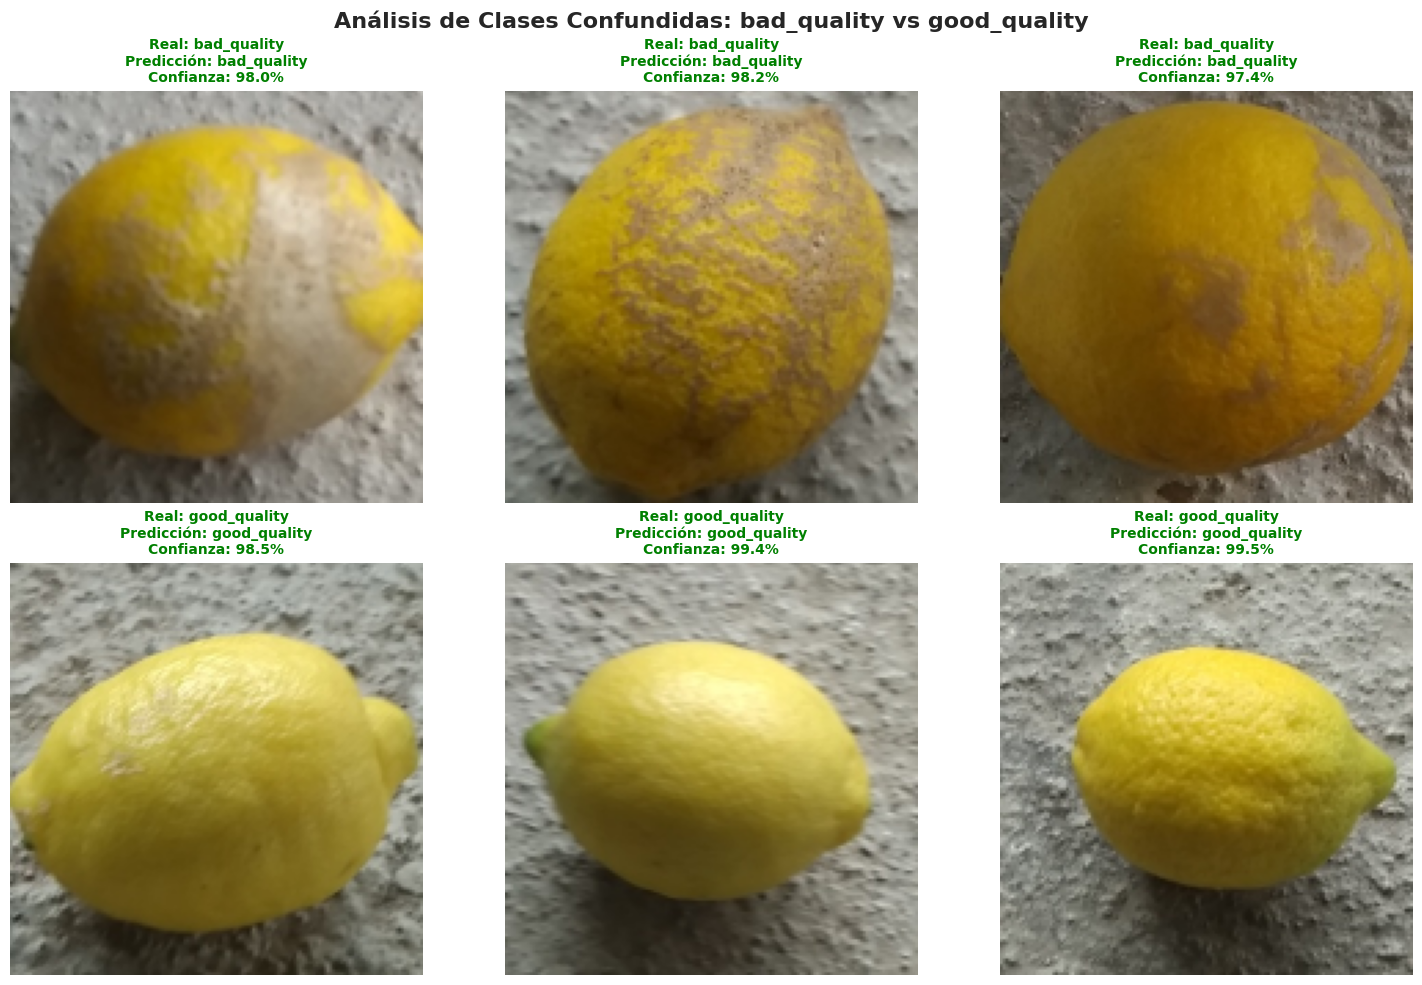


💡 EXPLICACIÓN DE LA CONFUSIÓN:
----------------------------------------------------------------------------------------------------
El modelo confunde frecuentemente 'bad_quality' con 'good_quality' debido a:
   1. Similitudes visuales en textura y color entre ambas clases
   2. Variabilidad intra-clase: algunas imágenes de 'bad_quality' pueden tener
      características que se solapan con 'good_quality'
   3. Condiciones de iluminación o ángulo de captura similares
   4. Posible ambigüedad en la frontera entre categorías



In [ ]:
# Encontrar índices de imágenes de cada clase en el test set
indices_clase_real = np.where(y_test == confused_pair[0])[0]
indices_clase_predicha_correcta = np.where(y_test == confused_pair[1])[0]

# Seleccionar 3 ejemplos aleatorios de cada clase
np.random.seed(42)
ejemplos_real = np.random.choice(indices_clase_real, min(3, len(indices_clase_real)), replace=False)
ejemplos_predicha = np.random.choice(indices_clase_predicha_correcta, min(3, len(indices_clase_predicha_correcta)), replace=False)

# Crear visualización
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'Análisis de Clases Confundidas: {clase_real} vs {clase_predicha}',
             fontsize=16, fontweight='bold')

# Mostrar ejemplos de la clase real
for i, idx in enumerate(ejemplos_real):
    ax = axes[0, i]
    ax.imshow(X_test[idx])
    pred_class = clases[y_pred_classes_best[idx]]
    true_class = clases[y_test[idx]]
    confidence = y_pred_best[idx][y_pred_classes_best[idx]] * 100

    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f'Real: {true_class}\nPredicción: {pred_class}\nConfianza: {confidence:.1f}%',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

# Mostrar ejemplos de la clase que se predice incorrectamente
for i, idx in enumerate(ejemplos_predicha):
    ax = axes[1, i]
    ax.imshow(X_test[idx])
    pred_class = clases[y_pred_classes_best[idx]]
    true_class = clases[y_test[idx]]
    confidence = y_pred_best[idx][y_pred_classes_best[idx]] * 100

    color = 'green' if pred_class == true_class else 'red'
    ax.set_title(f'Real: {true_class}\nPredicción: {pred_class}\nConfianza: {confidence:.1f}%',
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

axes[0, 0].set_ylabel(f'Ejemplos de:\n{clase_real}', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel(f'Ejemplos de:\n{clase_predicha}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.3.4 Limitaciones y Propuesta de Mejora (0.1 pts)

In [ ]:
# d) Limitaciones - Clase con peor F1-score
print("\n" + "="*100)
print(" "*30 + "4.3.4 LIMITACIONES Y PROPUESTA DE MEJORA")
print("="*100)

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred_classes_best, labels=range(len(clases)), zero_division=0
)

# Identificar clase con peor F1-score
worst_class_idx = np.argmin(f1_per_class)
worst_class_name = clases[worst_class_idx]

print(f"\n CLASE CON PEOR DESEMPEÑO:")
print("-" * 100)
print(f"   Clase: {worst_class_name}")
print(f"   F1-Score: {f1_per_class[worst_class_idx]:.4f} ({f1_per_class[worst_class_idx]*100:.2f}%)")

# Mostrar métricas detalladas de esa clase
print(f"\n MÉTRICAS DETALLADAS - {worst_class_name}:")
print("-" * 100)
print(f"   Precision: {precision_per_class[worst_class_idx]:.4f} ({precision_per_class[worst_class_idx]*100:.2f}%)")
print(f"   Recall: {recall_per_class[worst_class_idx]:.4f} ({recall_per_class[worst_class_idx]*100:.2f}%)")
print(f"   F1-Score: {f1_per_class[worst_class_idx]:.4f} ({f1_per_class[worst_class_idx]*100:.2f}%)")
print(f"   Soporte (# muestras): {support_per_class[worst_class_idx]}")


                              4.3.4 LIMITACIONES Y PROPUESTA DE MEJORA

⚠️ CLASE CON PEOR DESEMPEÑO:
----------------------------------------------------------------------------------------------------
   Clase: bad_quality
   F1-Score: 0.9338 (93.38%)

📊 MÉTRICAS DETALLADAS - bad_quality:
----------------------------------------------------------------------------------------------------
   Precision: 0.9845 (98.45%)
   Recall: 0.8881 (88.81%)
   F1-Score: 0.9338 (93.38%)
   Soporte (# muestras): 143

🔍 DIAGNÓSTICO:
----------------------------------------------------------------------------------------------------
   Problema principal: RECALL BAJO
   Interpretación: El modelo no detecta suficientes instancias verdaderas de esta clase

💡 ESTRATEGIA PROPUESTA PARA MEJORAR 'bad_quality':
----------------------------------------------------------------------------------------------------
   1. DATA AUGMENTATION ESPECÍFICO:
      - Aplicar augmentation más agresivo solo para 'bad_qualit